<a href="https://colab.research.google.com/github/pzangra/Progetto-Icu/blob/main/mimiciv_3_9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# mount drive, pip install, import

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install xgboost lightgbm shap tableone missingpy missingno optuna

import os
import logging
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

import optuna
from sklearn.model_selection import cross_val_score

import shap
import xgboost as xgb
import lightgbm as lgb
from lightgbm.callback import log_evaluation

from scipy.sparse import csr_matrix

from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import KNNImputer
from sklearn.model_selection import StratifiedKFold, train_test_split, GridSearchCV
from sklearn.metrics import (
    roc_curve, auc, matthews_corrcoef, accuracy_score, roc_auc_score,
    confusion_matrix, ConfusionMatrixDisplay, classification_report, f1_score
)
from sklearn.linear_model import LogisticRegression
from matplotlib.backends.backend_pdf import PdfPages


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.6/41.6 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.6/233.6 kB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 5.9 MB/s eta 0:00:00


/usr/local/lib/python3.11/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


# functions

## adfinfo()

In [ ]:
#check dataframe
def adfinfo(adf):
    print(f"Shape :{adf.shape}")
    print(f"Columns: {adf.columns}")
    print(f"Data types: {adf.dtypes}")
    print(f"Missing values: {adf.isna().sum()}")

## stats_pdf()

In [ ]:
def stats_pdf(adf, output_pdf="boxplots_starting.pdf"):
    """
    Computes statistics for the adf DataFrame and saves them into a single PDF file.
    """
    excluded_columns = [col for col in adf.columns if "subject_id" in col.lower() or
                        "stay_id" in col.lower() or
                        "date" in col.lower()]
    filtered_adf = adf.drop(columns=excluded_columns, errors="ignore")


    stats_list = []
    for col in filtered_adf.columns:
        if pd.api.types.is_numeric_dtype(filtered_adf[col]):
            col_stats = {
                "Column": col,
                "Type": "Numerical",
                "Mean": round(filtered_adf[col].mean(skipna=True), 2),
                "Variance": round(filtered_adf[col].var(skipna=True), 2),
                "Std Dev": round(filtered_adf[col].std(skipna=True), 2),
                "Median": round(filtered_adf[col].median(skipna=True), 2),
                "Min": round(filtered_adf[col].min(skipna=True), 2),
                "Max": round(filtered_adf[col].max(skipna=True), 2),
                "Sum": round(filtered_adf[col].sum(skipna=True), 2),
                "Count": filtered_adf[col].notnull().sum()
            }
        else:
            col_stats = {
                "Column": col,
                "Type": "Categorical",
                "Mean": None,
                "Variance": None,
                "Std Dev": None,
                "Median": None,
                "Min": None,
                "Max": None,
                "Sum": None,
                "Count": filtered_adf[col].notnull().sum()
            }

        stats_list.append(col_stats)

    stats_df = pd.DataFrame(stats_list)


    with PdfPages(output_pdf) as pdf:
        fig, ax = plt.subplots(figsize=(12, len(stats_df) * 0.5 + 2))
        ax.axis('tight')
        ax.axis('off')
        table = ax.table(
            cellText=stats_df.values,
            colLabels=stats_df.columns,
            loc='center',
            cellLoc='center'
        )
        table.auto_set_font_size(False)
        table.set_fontsize(10)
        table.auto_set_column_width(col=list(range(len(stats_df.columns))))
        plt.title("Summary Statistics", fontsize=14, weight="bold")
        pdf.savefig(fig)
        plt.close()

        for col in filtered_adf.select_dtypes(include='number').columns:
            fig, ax = plt.subplots(figsize=(8, 4))
            filtered_adf[col].hist(bins=20, grid=False, ax=ax)
            ax.set_title(f"Histogram of {col}")
            ax.set_xlabel(col)
            ax.set_ylabel("Frequency")
            pdf.savefig(fig)
            plt.close()

            fig, ax = plt.subplots(figsize=(8, 4))
            filtered_adf.boxplot(column=col, ax=ax)
            ax.set_title(f"Boxplot of {col}")
            ax.set_ylabel(col)
            pdf.savefig(fig)
            plt.close()

    print(f"Analysis and graphs have been saved to '{output_pdf}'.")

## save_to_csv()

In [ ]:


def save_to_csv(data, file_name, sparse=False):
    """
    Saves a Pandas DataFrame or sparse matrix to a CSV file.

    Parameters:
    - data (pd.DataFrame or csr_matrix): The data to save. Can be a Pandas DataFrame or a sparse matrix.
    - file_name (str): The name of the CSV file (e.g., 'output.csv').
    - sparse (bool): If True, saves the sparse matrix in a compact sparse format; otherwise, converts to dense.

    Returns:
    - None
    """
    try:
        if isinstance(data, pd.DataFrame):

            data.to_csv(file_name, index=False)
        elif isinstance(data, csr_matrix):
            if sparse:
                sparse_df = pd.DataFrame({
                    'row': data.nonzero()[0],
                    'col': data.nonzero()[1],
                    'value': data.data
                })
                sparse_df.to_csv(file_name, index=False)
            else:
                dense_df = pd.DataFrame(data.toarray())
                dense_df.to_csv(file_name, index=False)
        else:
            raise ValueError("Input data must be a Pandas DataFrame or a sparse matrix (csr_matrix).")

        print(f"Data saved successfully to {file_name}")
    except Exception as e:
        print(f"An error occurred while saving the data: {e}")

## map_categorical()

In [ ]:
def map_categorical(X):
    X = X.copy()

    diagnosis_mapping = {'Sepsis': 1, 'SIRS': 0}
    X['diagnosis'] = X['diagnosis'].map(diagnosis_mapping)

    gender_mapping = {'M': 1, 'F': 0}
    X['gender'] = X['gender'].map(gender_mapping)

    return X

## zmap_categorical()

In [ ]:
def zmap_categorical(Z):
    Z = Z.copy()

    # Map 'diagnosis' to binary
    diagnosis_mapping = {'Sepsis': 1, 'SIRS': 0}
    Z['diagnosis'] = Z['diagnosis'].map(diagnosis_mapping)

    # Map 'gender' to binary
    gender_mapping = {'M': 1, 'F': 0}
    Z['gender'] = Z['gender'].map(gender_mapping)

    # Map 'language' to binary
    Z['language'] = Z['language'].apply(lambda x: 1 if x == 'English' else 0)

    def map_race(x):
        if pd.isnull(x):
            return 0  # Other
        x = x.upper()
        if 'HISPANIC' in x or 'LATINO' in x:
            return 1  # Hispanic
        elif 'BLACK' in x or 'AFRICAN' in x:
            return 2  # Black
        elif 'ASIAN' in x:
            return 3  # Asian
        elif 'WHITE' in x:
            return 4  # White
        else:
            return 0  # Other

    Z['race'] = Z['race'].apply(map_race)

    def map_insurance(x):
        if pd.isnull(x):
            return 0  # No pay/Other
        x = x.upper()
        if x == 'PRIVATE':
            return 3
        elif x == 'MEDICARE':
            return 2
        elif x == 'MEDICAID':
            return 1
        else:
            return 0  # No pay/Other

    Z['insurance'] = Z['insurance'].apply(map_insurance)

    return Z

## analyze_missing_by_demographics()

In [ ]:
def analyze_missing_by_demographics(df, demographics_cols, missing_count_col='missing_count'):
    missing_analysis = df.groupby(demographics_cols)[missing_count_col].mean().reset_index()

    missing_analysis.rename(columns={missing_count_col: 'Average Missing Count'}, inplace=True)

    missing_analysis = missing_analysis.sort_values(by='Average Missing Count', ascending=False)

    return missing_analysis

## test_mcar()

In [ ]:
import numpy as np
from scipy.stats import chi2_contingency
import matplotlib.pyplot as plt
import missingno as msno

def test_mcar_with_visualization(df, demographics, plot=True):
    if plot:
        plt.figure(figsize=(10, 6))
        msno.matrix(df)
        plt.title("Missing Data Matrix", fontsize=16)
        plt.show()

        plt.figure(figsize=(10, 6))
        msno.bar(df)
        plt.title("Missing Data Bar Plot", fontsize=16)
        plt.show()

        plt.figure(figsize=(10, 6))
        msno.heatmap(df)
        plt.title("Missing Data Heatmap", fontsize=16)
        plt.show()

        plt.figure(figsize=(10, 6))
        msno.dendrogram(df)
        plt.title("Missing Data Dendrogram", fontsize=16)
        plt.show()


    missing_analysis = df.groupby(demographics)['missing_count'].mean().reset_index()
    missing_analysis.rename(columns={'missing_count': 'Average Missing Count'}, inplace=True)
    missing_analysis.sort_values(by='Average Missing Count', ascending=False, inplace=True)

    missing_indicator = df.isnull().astype(int)

    missing_indicator = missing_indicator.loc[:, missing_indicator.sum(axis=0) > 0]
    if missing_indicator.empty:
        raise ValueError("No missing values found in the dataset for the MCAR test.")

    observed_freqs = np.dot(missing_indicator.T, (1 - missing_indicator))

    observed_freqs = observed_freqs[~(observed_freqs == 0).all(axis=1), :]
    observed_freqs = observed_freqs[:, ~(observed_freqs == 0).all(axis=0)]
    if observed_freqs.size == 0:
        raise ValueError("The contingency table is empty after filtering zero rows/columns.")

    chi2_stat, p_value, _, _ = chi2_contingency(observed_freqs, correction=False)

    return p_value, missing_analysis

## test_mnar()

In [ ]:
from sklearn.preprocessing import StandardScaler

def test_mnar(df, columns_to_test=None, max_iter=1000, threshold=0.6):
    if columns_to_test is None:
        columns_to_test = df.columns

    results = {}
    numeric_cols = df.select_dtypes(include=[np.number]).columns

    for col in columns_to_test:
        if col == 'missing_count':
            continue
        missing_mask = df[col].isnull().astype(int)

        if missing_mask.nunique() < 2:
            results[col] = {
                'auc': None,
                'MNAR_suspected': None,
                'note': 'No variation in missingness for this column.'
            }
            continue

        other_cols = [c for c in df.columns if c != col and c != 'missing_count']

        X = df[other_cols].fillna(df[other_cols].mean())
        y = missing_mask

        numeric_intersect = [c for c in X.columns if c in numeric_cols]

        scaler = StandardScaler()
        X_scaled = X.copy()
        X_scaled[numeric_intersect] = scaler.fit_transform(X_scaled[numeric_intersect])

        model = LogisticRegression(max_iter=max_iter)
        try:
            model.fit(X_scaled, y)
            y_pred_prob = model.predict_proba(X_scaled)[:, 1]
            auc = roc_auc_score(y, y_pred_prob)

            MNAR_suspected = auc < threshold

            results[col] = {
                'auc': auc,
                'MNAR_suspected': MNAR_suspected,
                'note': 'MNAR_suspected=True'
            }

        except Exception as e:
            results[col] = {
                'auc': None,
                'MNAR_suspected': None,
                'error': str(e)
            }

    return results

## compute_demographic_percentages()

In [ ]:
def compute_demographic_percentages_multi(Z, missing_threshold=10):
    insurance_categories = {
        3: "Private",
        2: "Medicare",
        1: "Medicaid",
        0: "No pay/Other"
    }

    categories = {
        'survived48h': Z[Z['d48h'] == 0],
        'nonSurvived48h': Z[Z['d48h'] == 1],
        'survived90d': Z[Z['d90d'] == 0],
        'nonSurvived90d': Z[Z['d90d'] == 1],
        'survivedinhosp': Z[Z['dinhosp'] == 0],
        'nonSurvivedinhosp': Z[Z['dinhosp'] == 1],
        f"Missing>{missing_threshold}": Z[Z['missing_count'] > missing_threshold]
    }

    demographic_cols = ['insurance', 'race', 'language', 'gender']

    results_by_insurance = {}

    for ins_val, ins_name in insurance_categories.items():
        subset = Z[Z['insurance'] == ins_val]

        results = {cat: {} for cat in categories}

        for cat, df_cat in categories.items():
            df_cat_insurance = df_cat[df_cat['insurance'] == ins_val]

            for demo_col in demographic_cols:
                if len(df_cat_insurance) > 0:
                    cat_counts = df_cat_insurance[demo_col].value_counts(normalize=True) * 100
                else:
                    cat_counts = pd.Series({val: 0 for val in df_cat[demo_col].unique()})

                for val in sorted(df_cat[demo_col].dropna().unique()):
                    col_key = f"{demo_col}{val}"
                    results[cat][col_key] = round(cat_counts.get(val, 0), 2)

                if df_cat_insurance.empty:
                    unique_vals = df_cat[demo_col].dropna().unique()
                    for val in unique_vals:
                        col_key = f"{demo_col}{val}"
                        if col_key not in results[cat]:
                            results[cat][col_key] = 0

        results_df = pd.DataFrame(results).T
        results_by_insurance[ins_name] = results_df

    return results_by_insurance

## transform_features()

In [ ]:
def transform_data(X, encoder, columns_to_encode):
    encoded_sparse = encoder.transform(X[columns_to_encode])
    encoded_columns = encoder.get_feature_names_out(columns_to_encode)
    encoded_df = pd.DataFrame(
        encoded_sparse, columns=encoded_columns, index=X.index
    )

    X_encoded = pd.concat(
        [X.drop(columns=columns_to_encode), encoded_df],
        axis=1
    )

    return X_encoded

## treat_outliers_train()

In [ ]:
def treat_outliers_train(X_train, columns):
    thresholds = {}
    for col in columns:
        if col in X_train.columns:
            Q1 = X_train[col].quantile(0.25)
            Q3 = X_train[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            thresholds[col] = (lower_bound, upper_bound)
            mask = (X_train[col] < lower_bound) | (X_train[col] > upper_bound)
            X_train.loc[mask, col] = np.nan
    return X_train, thresholds

## treat_outliers_test()

In [ ]:
def treat_outliers_test(X_test, columns, thresholds):
    for col in columns:
        if col in X_test.columns and col in thresholds:
            lower_bound, upper_bound = thresholds[col]
            X_test.loc[:, col] = X_test[col].apply(
                lambda x: np.nan if x < lower_bound or x > upper_bound else x
            )
    return X_test

## process_missing_values()

In [ ]:
def process_missing_values_knn(X, n_neighbors=50, imputer=None):
    numeric_columns = X.select_dtypes(include='number').columns
    if imputer is None:
        imputer = KNNImputer(n_neighbors=n_neighbors, weights="uniform")
        X[numeric_columns] = imputer.fit_transform(X[numeric_columns])
    else:
        X[numeric_columns] = imputer.transform(X[numeric_columns])
    return X, imputer

## save_model_results_to_pdf()

In [ ]:
def save_model_results_to_pdf(results_by_model, pdf, target_name=None):
    """
    Save evaluation metrics, confusion matrices, ROC curves, SHAP plots, and additional metrics
    for all models to a PDF.

    This function accepts either a flat dictionary of model results (which may include non-model
    keys such as an imputer) or a nested dictionary keyed by target names. It filters out non-model
    keys and skips any results that do not include the required keys.

    Parameters:
      - results_by_model (dict): Results dictionary.
      - pdf: a PdfPages object.
      - target_name (str, optional): If provided, this target name will be used instead of "target"
        when printing the results.
    """
    import matplotlib.pyplot as plt
    from sklearn.metrics import ConfusionMatrixDisplay

    if not results_by_model:
        print("No results to save in PDF.")
        return

    # If results_by_model is flat (contains 'imputer'), wrap it into a dictionary with key given by target_name.
    if 'imputer' in results_by_model:
        models = {k: v for k, v in results_by_model.items() if k != 'imputer'}
        if target_name is None:
            target_name = 'target'
        targets = {target_name: models}
    else:
        targets = results_by_model

    # Loop over targets (or use 'target' if flat)
    for target_name, components in targets.items():
        # If the components are nested under a 'models' key, extract them;
        # otherwise, assume components itself is the dictionary of models.
        if isinstance(components, dict) and 'models' in components:
            models = components.get('models', {})
        else:
            models = components

        if not models:
            print(f"No models found for target '{target_name}'. Skipping.")
            continue

        # Process each model’s results.
        for model_name, results in models.items():
            # Skip non-model keys.
            if model_name.lower() == 'knnimputer':
                continue
            if results is None:
                print(f"No results for {model_name} in {target_name}. Skipping.")
                continue

            # Verify that the results include the required keys.
            required_keys = {
                'accuracy', 'auc', 'mcc', 'f1_score', 'sensitivity',
                'specificity', 'ppv', 'npv', 'classification_report',
                'confusion_matrix', 'roc_curve', 'y_test', 'y_pred'
            }
            if not isinstance(results, dict) or not required_keys.issubset(results.keys()):
                print(f"Results for {model_name} in {target_name} are incomplete or malformed. Skipping.")
                continue

            # Compile evaluation text.
            eval_text = (
                f"Model: {model_name.upper()} for {target_name}\n"
                f"Accuracy: {results['accuracy']:.2f}\n"
                f"AUC-ROC: {results['auc']:.2f}\n"
                f"MCC: {results['mcc']:.2f}\n"
                f"F1 Score: {results['f1_score']:.2f}\n"
                f"Sensitivity (SE): {results['sensitivity']:.2f}\n"
                f"Specificity (SP): {results['specificity']:.2f}\n"
                f"Positive Predictive Value (PPV): {results['ppv']:.2f}\n"
                f"Negative Predictive Value (NPV): {results['npv']:.2f}\n\n"
                f"Classification Report:\n{results['classification_report']}\n"
            )

            # Create a figure with the evaluation text.
            fig_text, ax_text = plt.subplots(figsize=(8, 6))
            ax_text.axis('off')
            ax_text.text(0.01, 0.99, eval_text, fontsize=10, va='top', wrap=True)
            pdf.savefig(fig_text)
            plt.close(fig_text)

            # Plot and add the confusion matrix.
            try:
                fig_cm, ax_cm = plt.subplots(figsize=(8, 6))
                ConfusionMatrixDisplay.from_predictions(
                    y_true=results['y_test'],
                    y_pred=results['y_pred'],
                    cmap='Blues',
                    ax=ax_cm
                )
                ax_cm.set_title(f"Confusion Matrix - {model_name.upper()} ({target_name})")
                pdf.savefig(fig_cm)
                plt.close(fig_cm)
            except Exception as e:
                print(f"Error plotting confusion matrix for {model_name} in {target_name}: {e}")

            # Plot and add the ROC curve.
            try:
                fig_roc, ax_roc = plt.subplots(figsize=(8, 6))
                fpr, tpr, _ = results['roc_curve']
                ax_roc.plot(fpr, tpr, label=f"AUC = {results['auc']:.2f}", color='darkorange', lw=2)
                ax_roc.plot([0, 1], [0, 1], linestyle="--", color="gray")
                ax_roc.set_title(f"ROC Curve - {model_name.upper()} ({target_name})")
                ax_roc.set_xlabel("False Positive Rate")
                ax_roc.set_ylabel("True Positive Rate")
                ax_roc.legend(loc="lower right")
                ax_roc.grid(True)
                pdf.savefig(fig_roc)
                plt.close(fig_roc)
            except Exception as e:
                print(f"Error plotting ROC curve for {model_name} in {target_name}: {e}")

            # Add SHAP summary plot if available.
            if 'shap_summary_plot' in results and results['shap_summary_plot'] is not None:
                shap_summary_fig = results['shap_summary_plot']
                if isinstance(shap_summary_fig, plt.Figure):
                    pdf.savefig(shap_summary_fig)
                    plt.close(shap_summary_fig)
                else:
                    print(f"SHAP summary for {model_name} in {target_name} is not a valid matplotlib figure. Skipping.")

            # Add probability distribution plot if available.
            if 'probability_distribution' in results and results['probability_distribution'] is not None:
                prob_dist_fig = results['probability_distribution']
                if isinstance(prob_dist_fig, plt.Figure):
                    pdf.savefig(prob_dist_fig)
                    plt.close(prob_dist_fig)
                else:
                    print(f"Probability distribution for {model_name} in {target_name} is not a valid matplotlib figure. Skipping.")

            # Optionally, add any SHAP force plots.
            if 'shap_force_plots' in results and results['shap_force_plots']:
                for idx, shap_force_fig in enumerate(results['shap_force_plots'], start=1):
                    if isinstance(shap_force_fig, plt.Figure):
                        fig_force, ax_force = plt.subplots(figsize=(15, 5))
                        ax_force.axis('off')
                        ax_force.text(
                            0.5, 0.95,
                            f"SHAP Force Plot {idx} - {model_name.upper()} ({target_name})",
                            fontsize=12, ha='center', va='top', wrap=True
                        )
                        pdf.savefig(shap_force_fig)
                        plt.close(shap_force_fig)
                    else:
                        print(f"SHAP force plot {idx} for {model_name} in {target_name} is not a valid matplotlib figure. Skipping.")

            if 'shap_histogram' in results and results['shap_histogram'] is not None:
                pdf.savefig(results['shap_histogram'])
                plt.close(results['shap_histogram'])
                print("All model results have been saved to the PDF successfully.")


## shap_treeexplainer()

In [ ]:
def shap_treexplainer(model, test_df, model_name="model"):
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(test_df)
    print("Generating SHAP summary plot...")
    plt.figure()
    shap.summary_plot(shap_values, test_df, show=False)
    summary_fig = plt.gcf()
    plt.close()
    return summary_fig

## preprocess_data()

In [ ]:
def preprocess_data(X_train, X_test, columns_to_treat):
    print(f"Before preprocessing: X_train={X_train.shape}, X_test={X_test.shape}")

    # Identify numeric columns
    numeric_columns = X_train.select_dtypes(include=['int64', 'float64']).columns

    # Create KNN Imputer and fit ONLY on X_train
    imputer = KNNImputer(n_neighbors=50, weights="uniform")
    imputer.fit(X_train[numeric_columns])

    # Impute both X_train and X_test using the fitted imputer
    X_train_imputed = pd.DataFrame(
        imputer.transform(X_train[numeric_columns]),
        columns=numeric_columns,
        index=X_train.index
    )
    X_test_imputed = pd.DataFrame(
        imputer.transform(X_test[numeric_columns]),
        columns=numeric_columns,
        index=X_test.index
    )

    # Update the original DataFrames with the imputed values
    X_train[numeric_columns] = X_train_imputed
    X_test[numeric_columns] = X_test_imputed

    print("Missing values imputed initially.")

    # Treat outliers in X_train and get thresholds
    X_train, thresholds = treat_outliers_train(X_train, columns_to_treat)

    # Treat outliers in X_test using thresholds from X_train
    X_test = treat_outliers_test(X_test, columns_to_treat, thresholds)
    print("Outliers treated")

    # Re-impute after outlier treatment
    X_train[numeric_columns] = pd.DataFrame(
        imputer.transform(X_train[numeric_columns]),
        columns=numeric_columns,
        index=X_train.index
    )
    X_test[numeric_columns] = pd.DataFrame(
        imputer.transform(X_test[numeric_columns]),
        columns=numeric_columns,
        index=X_test.index
    )
    print("Outliers treated and missing values re-imputed.")

    # Create encoded copies
    X_train_encoded = X_train.copy()
    X_test_encoded = X_test.copy()

    print(f"After preprocessing: X_train_encoded={X_train_encoded.shape}, X_test_encoded={X_test_encoded.shape}")

    return X_train_encoded, X_test_encoded, imputer

## preprocess_z()

In [ ]:
def preprocess_z(Z_train, Z_test, columns_to_treat):
    print(f"Before preprocessing: Z_train={Z_train.shape}, Z_test={Z_test.shape}")

    imputer = KNNImputer(n_neighbors=50, weights="uniform")
    numeric_columns = Z_train.select_dtypes(include='number').columns

    imputer.fit(Z_train[numeric_columns])

    Z_train.loc[:, numeric_columns] = imputer.transform(Z_train[numeric_columns])
    Z_test.loc[:, numeric_columns] = imputer.transform(Z_test[numeric_columns])
    print("Missing values imputed initially.")

    Z_train, thresholds = treat_outliers_train(Z_train, columns_to_treat)

    Z_test = treat_outliers_test(Z_test, columns_to_treat, thresholds)
    print("Outliers treated")

    # Re-impute after outlier treatment
    Z_train.loc[:, numeric_columns] = imputer.transform(Z_train[numeric_columns])
    Z_test.loc[:, numeric_columns] = imputer.transform(Z_test[numeric_columns])
    print("Outliers treated and missing values re-imputed.")

    Z_train_encoded = Z_train.copy()
    Z_test_encoded = Z_test.copy()

    print(f"After preprocessing: Z_train_encoded={Z_train_encoded.shape}, Z_test_encoded={Z_test_encoded.shape}")

    return Z_train_encoded, Z_test_encoded, imputer

## preprocess_Z_for_evaluation(

In [ ]:
def preprocess_z_for_evaluation(Z, trained_imputer, model_feature_cols, demographic_cols_to_drop, demographic_cols_for_stratification):
    """
    Dataframe Z contiene sia le feature per il modello che le variabili demografiche.

    Questa funzione:
      - Estrae da Z le feature del modello (usando model_feature_cols)
      - Applica l’imputer (se fornito) alle colonne numeriche delle feature
      - Estrae le colonne demografiche (usando demographic_cols_for_stratification)

    Ritorna:
       X_model: dataframe con le feature per il modello
       demographics: dataframe con le colonne demografiche
    """
    # Estrae le feature del modello
    X_model = Z[model_feature_cols].copy()
    if trained_imputer is not None:
        numeric_columns = X_model.select_dtypes(include='number').columns
        X_model[numeric_columns] = trained_imputer.transform(X_model[numeric_columns])
    # Estrae le colonne demografiche
    demographics = Z[demographic_cols_for_stratification].copy()
    return X_model, demographics


## stratify_performance()

In [ ]:
def stratify_performance(demographics_df, y_true, y_pred, demographic_cols):
    for demo_col in demographic_cols:
        if demo_col not in demographics_df.columns:
            print(f"Column {demo_col} not found in demographics DataFrame. Skipping.")
            continue
        print(f"\n=== Stratification by {demo_col} ===")
        groups = demographics_df[demo_col].dropna().unique()
        for grp in groups:
            idx = demographics_df[demo_col] == grp
            grp_y_true = y_true[idx]
            grp_y_pred = y_pred[idx]
            if len(grp_y_true) == 0:
                continue
            grp_acc = accuracy_score(grp_y_true, grp_y_pred)
            grp_auc = roc_auc_score(grp_y_true, grp_y_pred)
            grp_mcc = matthews_corrcoef(grp_y_true, grp_y_pred)
            grp_f1 = f1_score(grp_y_true, grp_y_pred)
            print(f"  Group: {demo_col} = {grp}")
            print(f"    Accuracy: {grp_acc:.2f}")
            print(f"    AUC-ROC: {grp_auc:.2f}")
            print(f"    MCC: {grp_mcc:.2f}")
            print(f"    F1 Score: {grp_f1:.2f}")

## missing_count()

In [ ]:
def add_missing_count(df, new_column_name='missing_count'):

    if new_column_name in df.columns:
        raise ValueError(f"The column '{new_column_name}' already exists in the DataFrame.")

    df[new_column_name] = df.isnull().sum(axis=1)

    return df

## fit and test distributions

In [ ]:
from scipy.stats import norm, lognorm, gamma, beta, weibull_min, expon, rayleigh, t, kstest

default_distributions_to_test = {
    "norm": norm,
    "lognorm": lognorm,
    "gamma": gamma,
    "beta": beta,
    "weibull_min": weibull_min,
    "expon": expon,
    "rayleigh": rayleigh,
    "t": t,
}

distribution_results_cache = None

def fit_and_test_distributions(df, continuous_cols, distributions=None, save_path=None):
    global distribution_results_cache
    if distributions is None:
        distributions = default_distributions_to_test

    if distribution_results_cache is not None:
        print("Using cached distribution results.")
        return distribution_results_cache

    results = {}

    for column in continuous_cols:
        data = df[column].dropna()
        if data.empty:
            results[column] = {"type": "continuous", "best_fit": None, "error": "no data"}
            continue

        best_fit = None
        best_stat = float('inf')

        for name, dist in distributions.items():
            try:
                params = dist.fit(data)
                stat, p_value = kstest(data, name, args=params)
                if stat < best_stat:
                    best_stat = stat
                    best_fit = {
                        "distribution": name,
                        "parameters": params,
                        "ks_stat": stat,
                        "p_value": p_value
                    }
            except Exception as e:
                print(f"Failed to fit {name} on {column}: {e}")

        if best_fit is None:
            print(f"No parametric distribution could be fit for column {column}.")
        results[column] = {"type": "continuous", "best_fit": best_fit}

    distribution_results_cache = results

    if save_path:
        with open(save_path, 'w') as f:
            json.dump(results, f, default=str, indent=4)

    return results


## normalize_data()

In [ ]:
def normalize_data(X_train, X_test, distribution_results):
    """
    For each continuous (nonbinary) column in X_train, if a best-fit distribution was found,
    use its CDF to map data into the standard normal space (via the norm.ppf).
    If no best-fit is found for a column, the empirical CDF is used as a fallback.
    """
    from scipy import stats
    X_train_normal = X_train.copy()
    X_test_normal = X_test.copy()

    # Loop only over columns for which we computed a distribution fit.
    for column in X_train.columns:
        # Skip if the column is binary or nearly binary.
        if X_train[column].dropna().nunique() <= 2:
            print(f"Skipping normalization for binary column {column}.")
            continue

        if column not in distribution_results:
            print(f"Skipping column {column}: No distribution result found.")
            continue

        dist_info = distribution_results[column]
        best_fit = dist_info.get("best_fit", None)

        if best_fit is None:
            print(f"No best-fit found for column {column}; applying empirical quantile transformation.")
            # Compute the empirical CDF (using ranking) and then map to the normal quantiles.
            ecdf_train = X_train[column].rank(method='average') / (len(X_train[column]) + 1)
            ecdf_test = X_test[column].rank(method='average') / (len(X_test[column]) + 1)
            X_train_normal[column] = stats.norm.ppf(ecdf_train)
            X_test_normal[column] = stats.norm.ppf(ecdf_test)
        else:
            dist_name = best_fit["distribution"]
            params = best_fit["parameters"]
            try:
                # Get the corresponding distribution from scipy.stats.
                dist = getattr(stats, dist_name, None)
                if dist is None:
                    print(f"Skipping {column}: Distribution {dist_name} not found in scipy.stats.")
                    continue

                # Use the fitted distribution's CDF to transform the data.
                cdf_train = dist.cdf(X_train[column], *params)
                cdf_test = dist.cdf(X_test[column], *params)

                # Avoid extreme values that would produce ±inf after applying norm.ppf.
                epsilon = 1e-6
                cdf_train = np.clip(cdf_train, epsilon, 1 - epsilon)
                cdf_test = np.clip(cdf_test, epsilon, 1 - epsilon)

                norm_ppf_train = stats.norm.ppf(cdf_train)
                norm_ppf_test = stats.norm.ppf(cdf_test)

                X_train_normal[column] = norm_ppf_train
                X_test_normal[column] = norm_ppf_test

            except Exception as e:
                print(f"Error normalizing column {column}: {e}")

    return X_train_normal, X_test_normal


## standardize_data()

In [ ]:
def standardize_data(X_train, X_test):
    """
    Standardizes the numeric columns (i.e. subtract the mean and divide by the standard deviation)
    using sklearn’s StandardScaler.
    """
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    numeric_cols = X_train.select_dtypes(include=[np.number]).columns

    scaler.fit(X_train[numeric_cols])
    X_train_standard = X_train.copy()
    X_test_standard = X_test.copy()

    X_train_standard[numeric_cols] = scaler.transform(X_train[numeric_cols])
    X_test_standard[numeric_cols] = scaler.transform(X_test[numeric_cols])

    return X_train_standard, X_test_standard

## plot_distribution_fit()

In [ ]:
def plot_distribution_fit(data, distribution_info, column, distributions=default_distributions_to_test):
    plt.figure(figsize=(8, 6))
    plt.hist(data, bins=30, density=True, alpha=0.6, color='g', label='Data Histogram')

    # Retrieve the distribution using the key from distribution_info
    dist = distributions[distribution_info['distribution']]
    params = distribution_info['parameters']
    x = np.linspace(data.min(), data.max(), 1000)
    pdf_fitted = dist.pdf(x, *params)
    plt.plot(x, pdf_fitted, 'r-', label=f"Fitted {distribution_info['distribution'].capitalize()} PDF")

    plt.title(f"Distribution Fit for {column}")
    plt.xlabel(column)
    plt.ylabel("Density")
    plt.legend()
    plt.show()

##save_fit_results_table(

In [ ]:
def save_fit_results_table(fit_results, output_csv="fit_results.csv"):
    """
    Converts the fit_results dictionary (returned by fit_and_test_distributions)
    into a table with columns for the variable name, best-fit distribution, parameters,
    KS statistic, and p-value. Numeric values are rounded to two decimals except for very
    small p-values which are formatted in scientific notation.
    The table is then saved as a CSV file.

    Parameters:
        fit_results (dict): The dictionary with the fitted results.
        output_csv (str): The path and filename for the output CSV file.

    Returns:
        None
    """
    rows = []
    for var, info in fit_results.items():
        best_fit = info.get("best_fit")
        if best_fit is None:
            row = {
                "Variable": var,
                "Distribution": None,
                "Parameters": None,
                "KS_Stat": None,
                "P_Value": None
            }
        else:
            # Retrieve distribution name and parameters
            distribution = best_fit.get("distribution")
            parameters = best_fit.get("parameters")
            # Round numeric parameters to 2 decimals
            rounded_params = []
            for p in parameters:
                try:
                    rounded_params.append(round(p, 2))
                except Exception:
                    rounded_params.append(p)
            params_str = str(tuple(rounded_params))

            # Format KS statistic (rounding is usually fine)
            ks_stat_val = best_fit.get("ks_stat", None)
            ks_stat_formatted = round(ks_stat_val, 2) if ks_stat_val is not None else None

            # Format p-value in scientific notation to preserve small numbers
            p_val = best_fit.get("p_value", None)
            p_val_formatted = "{:.2e}".format(p_val) if p_val is not None else None

            row = {
                "Variable": var,
                "Distribution": distribution,
                "Parameters": params_str,
                "KS_Stat": ks_stat_formatted,
                "P_Value": p_val_formatted
            }
        rows.append(row)

    df_results = pd.DataFrame(rows)
    df_results.to_csv(output_csv, index=False)
    print(f"Fit results table saved to '{output_csv}'.")

## optimize_model_with_advanced_search()

In [ ]:
def optimize_model_with_advanced_search(
    estimator,
    X_train,
    y_train,
    param_distributions,
    scoring='roc_auc',
    cv=3,
    n_iter_random=50,
    n_trials_optuna=100,
    random_state=42,
    **fit_params
):
    """
    Advanced hyperparameter optimization using multiple strategies:
    1. Randomized Search
    2. Optuna Bayesian Optimization
    3. Refined Grid Search

    Parameters:
    -----------
    estimator : sklearn-compatible model
        The machine learning model to optimize
    X_train : array-like
        Training feature matrix
    y_train : array-like
        Training target variable
    param_distributions : dict
        Initial parameter distributions for search
    scoring : str, optional (default='roc_auc')
        Metric to optimize
    cv : int, optional (default=3)
        Number of cross-validation folds
    n_iter_random : int, optional (default=50)
        Number of iterations for RandomizedSearchCV
    n_trials_optuna : int, optional (default=100)
        Number of trials for Optuna optimization
    random_state : int, optional (default=42)
        Random seed for reproducibility

    Returns:
    --------
    tuple : (best_model, best_params, best_score)
        Optimized model, its parameters, and performance score
    """
    # Phase 1: Randomized Search
    print("\n[Phase 1] Randomized Search...")
    rand_search = RandomizedSearchCV(
        estimator=estimator,
        param_distributions=param_distributions,
        n_iter=n_iter_random,
        cv=cv,
        scoring=scoring,
        random_state=random_state,
        n_jobs=-1,
        verbose=1
    )
    rand_search.fit(X_train, y_train)

    best_random_params = rand_search.best_params_
    print("Best parameters from RandomizedSearchCV:")
    print(best_random_params)

    # Phase 2: Optuna Bayesian Optimization
    print("\n[Phase 2] Optuna Bayesian Optimization...")
    def objective(trial):
        params = {}
        for param_name, param_dist in param_distributions.items():
            if isinstance(param_dist, list):
                params[param_name] = trial.suggest_categorical(param_name, param_dist)
            elif isinstance(param_dist, dict) and 'type' in param_dist:
                if param_dist['type'] == 'int':
                    params[param_name] = trial.suggest_int(
                        param_name,
                        param_dist.get('low', 1),
                        param_dist.get('high', 100)
                    )
                elif param_dist['type'] == 'float':
                    params[param_name] = trial.suggest_float(
                        param_name,
                        param_dist.get('low', 0.0),
                        param_dist.get('high', 1.0)
                    )

        model = type(estimator)(**params)

        if cv > 1:
            scores = cross_val_score(model, X_train, y_train, cv=cv, scoring=scoring)
            return np.mean(scores)
        else:
            model.fit(X_train, y_train)
            return model.score(X_train, y_train)

    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=n_trials_optuna)

    optuna_best_params = study.best_params
    print("Best parameters from Optuna:")
    print(optuna_best_params)

    # Phase 3: Refined Grid Search
    print("\n[Phase 3] Refined Grid Search...")
    def create_refined_param_grid(best_params, step_size=0.2):
        refined_grid = {}
        for param, value in best_params.items():
            if isinstance(value, int):
                refined_grid[param] = list(range(
                    max(1, int(value * (1 - step_size))),
                    int(value * (1 + step_size)) + 1
                ))
            elif isinstance(value, float):
                refined_grid[param] = np.linspace(
                    max(0, value * (1 - step_size)),
                    value * (1 + step_size),
                    num=5
                ).tolist()
            else:
                refined_grid[param] = [value]
        return refined_grid

    refined_param_grid = create_refined_param_grid(optuna_best_params)

    grid_search = GridSearchCV(
        estimator=type(estimator)(),
        param_grid=refined_param_grid,
        cv=cv,
        scoring=scoring,
        n_jobs=-1,
        verbose=1
    )
    grid_search.fit(X_train, y_train)

    best_params = grid_search.best_params_
    best_estimator = grid_search.best_estimator_

    # Compute final score
    if scoring == 'roc_auc':
        y_pred_prob = best_estimator.predict_proba(X_train)[:, 1]
        best_score = roc_auc_score(y_train, y_pred_prob)
    elif scoring == 'f1':
        y_pred = best_estimator.predict(X_train)
        best_score = f1_score(y_train, y_pred)
    else:
        best_score = grid_search.best_score_

    print(f"\nBest {scoring} score: {best_score:.4f}")
    print("Final Best Parameters:")
    print(best_params)

    return best_estimator, best_params, best_score

## refine_hyperparameters()

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

def refine_hyperparameters(
    model,
    X_train,
    y_train,
    param_distributions,
    scoring='roc_auc',
    cv=3,
    n_iter=50,
    random_state=42,
    grid_step_size=2,
    **fit_params
):
    print("\nStarting RandomizedSearchCV...")
    rand_search = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_distributions,
        n_iter=n_iter,
        cv=cv,
        scoring=scoring,
        **fit_params,
        random_state=random_state,
        n_jobs=-1,
        verbose=2
    )
    rand_search.fit(X_train, y_train)

    best_random_params = rand_search.best_params_
    print("Best parameters from RandomizedSearchCV:")
    print(best_random_params)

    refined_param_grid = {}

    def create_neighborhood(param_name, best_val):
        if isinstance(best_val, int):
            step = grid_step_size
            lower = max(best_val - step, 1)
            upper = best_val + step
            return list(range(lower, upper + 1, step))
        elif isinstance(best_val, float):
            step = grid_step_size * 0.1
            lower = max(best_val - step, 0.0001)
            upper = best_val + step
            return np.linspace(lower, upper, num=5).tolist()
        else:
            return [best_val]

    for param_name, best_val in best_random_params.items():
        refined_param_grid[param_name] = create_neighborhood(param_name, best_val)

    print("\nRefined parameter grid for GridSearchCV:")
    print(refined_param_grid)

    best_params, best_model, best_score = optimize_model_with_gridsearch(
        estimator=type(model)(),
        X_train=X_train,
        y_train=y_train,
        param_grid=refined_param_grid,
        cv_folds=cv,
        scoring=scoring,
        n_jobs=-1,
        verbose=2,
        **fit_params
    )

    print("\nBest parameters from GridSearchCV:")
    print(best_params)

    y_pred_prob = best_model.predict_proba(X_train)[:, 1]
    if scoring == 'f1':
        y_pred = best_model.predict(X_train)
        best_score = f1_score(y_train, y_pred)
    else:
        best_score = roc_auc_score(y_train, y_pred_prob)

    print(f"Best {scoring} score from GridSearchCV: {best_score:.4f}\n")

    return best_model, best_params, best_score

## optimize_model_with_gridseach()

In [ ]:
def optimize_model_with_gridsearch(
    estimator,
    X_train,
    y_train,
    param_grid,
    cv_folds=3,
    scoring='',
    n_jobs=-1,
    verbose=2,
    **fit_params
):
    grid_search = GridSearchCV(
        estimator=estimator,
        param_grid=param_grid,
        scoring=scoring,
        cv=cv_folds,
        n_jobs=n_jobs,
        verbose=verbose,
        **fit_params
    )
    grid_search.fit(X_train, y_train)

    best_params = grid_search.best_params_
    best_estimator = grid_search.best_estimator_
    best_score = grid_search.best_score_

    return best_params, best_estimator, best_score

## append_demographics_to_X()

In [ ]:
def append_demographics_to_X(X, Z, demographics_cols):

    # Ensure X and Z have the same number of rows
    if X.shape[0] != Z.shape[0]:
        raise ValueError("X and Z must have the same number of rows to append demographics.")

    # Reset indices to ensure alignment
    X_reset = X.reset_index(drop=True)
    Z_reset = Z.reset_index(drop=True)

    # Select the demographics columns
    demographics_data = Z_reset[demographics_cols]

    # Concatenate X with demographics columns
    X_with_demographics = pd.concat([X_reset, demographics_data], axis=1)

    return X_with_demographics

# data initialization



In [ ]:
# Load dataset
adf = pd.read_csv('/content/drive/MyDrive/data/data_31k.csv', sep=',')

# Drop unnecessary columns
adf.drop([
    'subject_id', 'stay_id', 'dod', 'icu_hours',
    'weight_kg', 'height',
    'icdcode_reason',
    'apacheii_md', 'apacheii_cr_h', 'apacheii_cr_hp', 'apacheiii',
    'max_rate_std',
    'zcrp_fdv',
    'fio2_apii', 'fio2_apiv', 'fio2_ecmoch', 'fio2_ecmo',
    'albumin_bg', 'albumin_urine_chem',
    'albumin_bl_chem_85', 'albumin_bl_chem_38', 'albumin_asc_chem', 'albumin_jointf_chem',
    'lactate_442', 'lactate_chem',
    'ph_fluid', 'po2_042', 'po2_bfluid', 'pco2_040', 'pco2_830',
    'crp_highsens', 'crp_bl_chem',
    'mpv', 'wbcc', 'inr', 'admission_type'
], axis=1, inplace=True)

# Copy and preprocess Z
Z = adf.copy()
Z = zmap_categorical(Z)
Z = add_missing_count(Z)
save_to_csv(Z, "Z.csv")

# Extract demographics data before dropping related columns
demographics_data = Z[['gender', 'race', 'language', 'insurance']].copy()

# Drop demographic columns from adf
adf.drop(['language', 'insurance', 'race'], axis=1, inplace=True)

# Display dataset information
adfinfo(adf)
stats_pdf(adf)

# Extract X and target variables
X = adf.drop(['d48h', 'd90d', 'dinhosp'], axis=1)
save_to_csv(X, 'X_before_mapping.csv')
X = map_categorical(X)

y_d48h = adf['d48h']
y_d90d = adf['d90d']
y_dinhosp = adf['dinhosp']

model_feature_cols = X.columns.tolist()

save_to_csv(X, 'X.csv')

# Define threshold for missing values (80% available, max 20% missing)
threshold = 0.8

# Identify valid rows where at least 80% of values are non-null
valid_X_rows = X.dropna(thresh=int(threshold * X.shape[1])).index
valid_Z_rows = Z.dropna(thresh=int(threshold * Z.shape[1])).index

# Keep only rows that are valid in both X and Z
valid_rows = valid_X_rows.intersection(valid_Z_rows)

# Filter X, Z, and target variables based on valid rows
X = X.loc[valid_rows]
Z = Z.loc[valid_rows]
y_d48h = y_d48h.loc[valid_rows]
y_d90d = y_d90d.loc[valid_rows]
y_dinhosp = y_dinhosp.loc[valid_rows]

print(f"New shape of X: {X.shape}")
print(f"New shape of Z: {Z.shape}")
print(f"New shape of y_d48h: {y_d48h.shape}")
print(f"New shape of y_d90d: {y_d90d.shape}")
print(f"New shape of y_dinhosp: {y_dinhosp.shape}")

# Save the filtered datasets
save_to_csv(X, 'X_filtered.csv')
save_to_csv(Z, 'Z_filtered.csv')
save_to_csv(pd.DataFrame({'d48h': y_d48h, 'd90d': y_d90d, 'dinhosp': y_dinhosp}), 'y_filtered.csv')

Data saved successfully to Z.csv
Shape :(31569, 51)
Columns: Index(['diagnosis', 'd48h', 'd90d', 'dinhosp', 'age', 'BMI', 'gender',
       'sirs_score', 'sofa_score', 'oasis', 'gcs', 'mechvent', 'vasopressor',
       'renal_replacement', 'mild_liver_disease', 'severe_liver_disease',
       'diabetes_with_cc', 'diabetes_without_cc', 'hypertension', 'copd',
       'crp_fdv', 'wbc_fdv', 'heart_rate', 'sbp', 'dbp', 'body_temp', 'spo2',
       'resp_rate', 'fio2', 'albumin_bl_chem', 'aniongap', 'bun',
       'calcium_chem', 'chloride_chem', 'creatinine_chem', 'glucose_chem',
       'sodium_chem', 'potassium_chem', 'magnesium_chem', 'lactate_813',
       'bicarbonate', 'ph', 'po2_821', 'pco2_818', 'hematocrit', 'hemoglobin',
       'platelet', 'NeuC', 'LymC', 'EoC', 'nl_ratio'],
      dtype='object')
Data types: diagnosis                object
d48h                      int64
d90d                      int64
dinhosp                   int64
age                       int64
BMI                   

In [ ]:
# Define columns by type
columns_by_type = {
    "categorical": [ ],
    "binary": [
        "d48h", "d90d", "dinhosp", "mechvent", "vasopressor", "diagnosis",
        "gender", "renal_replacement", "mild_liver_disease", "severe_liver_disease",
        "diabetes_with_cc", "diabetes_without_cc", "hypertension", "copd"
    ],
    "integr": ["age", "sirs_score", "sofa_score", "oasis"],
    "continuous": [
        "BMI", "gcs", "crp_fdv", "wbc_fdv", "heart_rate", "sbp", "dbp",
        "body_temp", "spo2", "resp_rate", "fio2", "albumin_bl_chem", "aniongap",
        "bun", "calcium_chem", "chloride_chem", "creatinine_chem", "glucose_chem",
        "sodium_chem", "potassium_chem", "magnesium_chem", "lactate_813",
        "bicarbonate", "ph", "po2_821", "pco2_818", "hematocrit", "hemoglobin",
        "platelet", "NeuC", "EoC", "LymC", "nl_ratio"
    ]
}


# Combine the continuous and integral columns into a single list of columns to fit
columns_to_fit = columns_by_type["continuous"] + columns_by_type["integr"]

# Call the distribution fitting function
fit_results_extended = fit_and_test_distributions(
    X,
    continuous_cols=columns_to_fit
)

# Loop over each column in our list and process the results
for col in columns_to_fit:
    print(f"=== Processing Column: {col} ===")

    # Retrieve the result for this column; if not available, skip it.
    result = fit_results_extended.get(col)
    if result is None:
        print(f"No result for column {col}.")
        continue

    # Print the entire fitting result dictionary for the column.
    print(result)

    # Check if the column is binary (or nearly binary)
    if X[col].dropna().nunique() <= 2:
        print(f"Skipping distribution plotting for binary column: {col}")
        continue

    # Retrieve the best-fit result, if it exists.
    best_fit = result.get("best_fit")
    if best_fit is not None:
        dist_name = best_fit["distribution"]
        params = best_fit["parameters"]
        print(f"Best-fit for {col}: {dist_name} with parameters {params}")
        # Plot the fitted distribution
        plot_distribution_fit(X[col], best_fit, col)
    else:
        print(f"No valid best-fit found for column: {col}")

save_fit_results_table(fit_results_extended, output_csv="fitted_distributions.csv")

/usr/local/lib/python3.11/dist-packages/scipy/stats/_continuous_distns.py:716: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/usr/local/lib/python3.11/dist-packages/scipy/stats/_continuous_distns.py:721: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  a, b = optimize.fsolve(func, (1.0, 1.0))
/usr/local/lib/python3.11/dist-packages/scipy/stats/_continuous_distns.py:6554: RuntimeWarning: divide by zero encountered in log
  return np.sum((1 + np.log(shifted/scale)/shape**2)/shifted)
/usr/local/lib/python3.11/dist-packages/scipy/stats/_continuous_distns.py:8751: RuntimeWarning: overflow encountered in divide
  s3 = (1/xm).sum()
/usr/local/lib/python3.11/dist-packages/scipy/stats/_continuous_distns.py:721: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  a, b = op

KeyboardInterrupt: 

### statistical_analysis_for_groups

In [ ]:
demographics = ['gender', 'race', 'language', 'insurance']

print("Overall MCAR and MNAR Analysis:")
try:
    mcar_p_value, missing_analysis = test_mcar_with_visualization(Z, demographics, plot=True)
    print("Missing Values Analysis by Demographics:")
    print(missing_analysis)
    print(f"MCAR Test P-Value: {mcar_p_value}")
    if mcar_p_value < 0.05:
        print("Missing data is NOT MCAR (could be MAR or MNAR).")
    else:
        print("Missing data is MCAR.")
except ValueError as e:
    print(f"Error during MCAR test: {e}")

mnar_results = test_mnar(Z)
print("\nMNAR Test Results (Overall):")
for col, res in mnar_results.items():
    print(f"{col}: {res}")

insurance_categories = {
    3: "Private",
    2: "Medicare",
    1: "Medicaid",
    0: "No pay/Other"
}

print("\nPer-Insurance MCAR and MNAR Analysis:")
for ins_val, ins_name in insurance_categories.items():
    subset = Z[Z['insurance'] == ins_val]
    if subset.empty:
        print(f"{ins_name} (code={ins_val}): No data available for MCAR/MNAR tests.")
        continue

    print(f"\nInsurance: {ins_name} (code={ins_val})")
    try:
        mcar_p_value_ins, missing_analysis_ins = test_mcar_with_visualization(subset, demographics, plot=False)
        print("Missing Values Analysis by Demographics (subset):")
        print(missing_analysis_ins)
        print(f"MCAR Test P-Value: {mcar_p_value_ins}")
        if mcar_p_value_ins < 0.05:
            print("Missing data is NOT MCAR (could be MAR or MNAR) for this insurance category.")
        else:
            print("Missing data is MCAR for this insurance category.")
    except ValueError as e:
        print(f"Error during MCAR test for {ins_name}: {e}")

    mnar_results_ins = test_mnar(subset)
    print("MNAR Test Results (subset):")
    for col, res in mnar_results_ins.items():
        print(f"{col}: {res}")

Z_bias_tables_by_insurance = compute_demographic_percentages_multi(Z, missing_threshold=10)

for ins_name, df in Z_bias_tables_by_insurance.items():
    print(f"\nDemographic Percentages with Missing Counts > 10 for Insurance: {ins_name}")
    print(df)

print("\nComparing survival rates across insurance types:")
for ins_val, ins_name in insurance_categories.items():
    subset = Z[Z['insurance'] == ins_val]
    if len(subset) > 0:
        survival_48h = 1 - subset['d48h'].mean()
        survival_90d = 1 - subset['d90d'].mean()
        survival_inhosp = 1 - subset['dinhosp'].mean()

        print(f"Insurance: {ins_name} (code={ins_val})")
        print(f"  48h Survival: {survival_48h:.2f}")
        print(f"  90d Survival: {survival_90d:.2f}")
        print(f"  In-Hospital Survival: {survival_inhosp:.2f}")
    else:
        print(f"Insurance: {ins_name} (code={ins_val}) - No records found.\n")

print("\nComparing survival rates across race types:")
for ins_val, ins_name in insurance_categories.items():
    subset = Z[Z['race'] == ins_val]
    if len(subset) > 0:
        survival_48h = 1 - subset['d48h'].mean()
        survival_90d = 1 - subset['d90d'].mean()
        survival_inhosp = 1 - subset['dinhosp'].mean()

        print(f"Race: {ins_name} (code={ins_val})")
        print(f"  48h Survival: {survival_48h:.2f}")
        print(f"  90d Survival: {survival_90d:.2f}")
        print(f"  In-Hospital Survival: {survival_inhosp:.2f}")
    else:
        print(f"Race: {ins_name} (code={ins_val}) - No records found.\n")

print("\nComparing survival rates across language types:")
for ins_val, ins_name in insurance_categories.items():
    subset = Z[Z['language'] == ins_val]
    if len(subset) > 0:
        survival_48h = 1 - subset['d48h'].mean()
        survival_90d = 1 - subset['d90d'].mean()
        survival_inhosp = 1 - subset['dinhosp'].mean()

        print(f"Language: {ins_name} (code={ins_val})")
        print(f"  48h Survival: {survival_48h:.2f}")
        print(f"  90d Survival: {survival_90d:.2f}")
        print(f"  In-Hospital Survival: {survival_inhosp:.2f}")
    else:
        print(f"Language: {ins_name} (code={ins_val}) - No records found.\n")

print("\nComparing survival rates across language types:")
for ins_val, ins_name in insurance_categories.items():
    subset = Z[Z['gender'] == ins_val]
    if len(subset) > 0:
        survival_48h = 1 - subset['d48h'].mean()
        survival_90d = 1 - subset['d90d'].mean()
        survival_inhosp = 1 - subset['dinhosp'].mean()

        print(f"Gender: {ins_name} (code={ins_val})")
        print(f"  48h Survival: {survival_48h:.2f}")
        print(f"  90d Survival: {survival_90d:.2f}")
        print(f"  In-Hospital Survival: {survival_inhosp:.2f}")
    else:
        print(f"Gender: {ins_name} (code={ins_val}) - No records found.\n")

# ML pipelines

## logistic_regression_model()

In [ ]:
def logistic_regression_model(X_train, X_test, y_train, y_test, target_name, model_name):
    """Train and evaluate a Logistic Regression model with SHAP analysis."""

    # Train logistic regression
    model = LogisticRegression(max_iter=10000, solver='saga')
    model.fit(X_train, y_train)

    # Predictions
    y_pred = model.predict(X_test)
    y_pred_prob = model.predict_proba(X_test)[:, 1]

    # Compute basic metrics
    accuracy = accuracy_score(y_test, y_pred)
    auc_score = roc_auc_score(y_test, y_pred_prob)
    mcc = matthews_corrcoef(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    classification_rep = classification_report(y_test, y_pred)
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

    # Compute confusion matrix–derived metrics
    tn, fp, fn, tp = conf_matrix.ravel()
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    ppv = tp / (tp + fp) if (tp + fp) > 0 else 0
    npv = tn / (tn + fn) if (tn + fn) > 0 else 0

    # SHAP Analysis
    shap_summary_fig = None
    shap_force_figs = []
    try:
        # Use a valid value (e.g. "interventional")
        explainer = shap.LinearExplainer(model, X_train, feature_perturbation="interventional")
        shap_values = explainer.shap_values(X_test)

        # Generate SHAP summary plot
        plt.figure(figsize=(12, 8))
        shap.summary_plot(shap_values, X_test, show=False)
        shap_summary_fig = plt.gcf()
        plt.close(shap_summary_fig)

        # Generate SHAP force plots for a few examples
        num_force_plots = min(5, len(y_test))
        for i in range(num_force_plots):
            plt.figure(figsize=(15, 5))
            rounded_shap_values = np.round(shap_values[i], 2)
            rounded_features = X_test.iloc[i].round(2)
            shap.force_plot(
                np.round(explainer.expected_value, 2),  # arrotonda il base value
                rounded_shap_values,
                rounded_features,
                matplotlib=True,
                show=False
            )
            force_fig = plt.gcf()
            shap_force_figs.append(force_fig)
            plt.close(force_fig)
    except Exception as e:
        print(f"SHAP analysis failed for {model_name} in target {target_name}: {e}")

    return {
        "model": model,
        "accuracy": accuracy,
        "auc": auc_score,
        "mcc": mcc,
        "f1_score": f1,
        "sensitivity": sensitivity,
        "specificity": specificity,
        "ppv": ppv,
        "npv": npv,
        "confusion_matrix": conf_matrix,
        "classification_report": classification_rep,
        "y_test": y_test,
        "y_pred": y_pred,
        "roc_curve": (fpr, tpr, thresholds),
        "shap_summary_plot": shap_summary_fig,
        "shap_force_plots": shap_force_figs,
    }

## run_models_for_target()



In [ ]:
def run_models_for_target(
    X,
    y,
    target_name,
    columns_to_treat=None,
    distribution_results=None,
    run_xgb_optimization=False,
    run_lgb_optimization=False,
    param_distributions_xgb=None,
    param_distributions_lgb=None,
    best_params_xgb=None,
    best_params_lgb=None,
    test_size=0.2,
    random_state=42,
    columns_to_encode=None,         # Nuovo parametro (opzionale)
    results_by_model=None           # Nuovo parametro (opzionale)
):
    """
    Splitta X e y in train e test, pre-processa i dati e allena diversi modelli per il target.

    (Nota: il parametro columns_to_encode viene accettato ma non utilizzato internamente,
    a meno che non si desideri integrare una trasformazione sui dati; qui è presente per compatibilità.)

    Al termine, se viene passato un dizionario results_by_model, i risultati vengono salvati in:
         results_by_model[target_name] = results

    Returns:
      results: un dizionario con chiavi 'lr_encoded', 'lr_normalized', 'lr_standardized', 'xgb', 'lgb' e 'imputer'.
    """
    from sklearn.model_selection import train_test_split
    import xgboost as xgb
    import lightgbm as lgb
    from matplotlib.backends.backend_pdf import PdfPages

    # Se non vengono fornite colonne da trattare, usa tutte le colonne
    if columns_to_treat is None:
        columns_to_treat = X.columns.tolist()

    # 1. Split dei dati
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, stratify=y, random_state=random_state
    )
    print(f"Data split: X_train: {X_train.shape}, X_test: {X_test.shape}")

    # 2. Preprocess dei dati (trattamento outlier, imputazione, etc.)
    X_train_pre, X_test_pre, imputer = preprocess_data(X_train, X_test, columns_to_treat)
    print("Preprocessing completed.")

    # 3. Allenamento di una regressione logistica sui dati pre-processati (encoded)
    print("Training logistic regression (encoded)...")
    lr_encoded_results = logistic_regression_model(
        X_train_pre, X_test_pre, y_train, y_test, target_name, "lr_encoded"
    )

    # 4. Normalizzazione e standardizzazione (se distribution_results è fornito, applica la normalizzazione)
    if distribution_results is not None:
        print("Normalizing data using provided distribution results...")
        X_train_norm, X_test_norm = normalize_data(X_train_pre, X_test_pre, distribution_results)
    else:
        print("No distribution results provided; skipping normalization.")
        X_train_norm, X_test_norm = X_train_pre.copy(), X_test_pre.copy()

    print("Standardizing data...")
    X_train_std, X_test_std = standardize_data(X_train_pre, X_test_pre)

    # 5. Allenamento di logistic regression sui dati normalizzati
    print("Training logistic regression (normalized)...")
    lr_normalized_results = logistic_regression_model(
        X_train_norm, X_test_norm, y_train, y_test, target_name, "lr_normalized"
    )

    # 6. Allenamento di logistic regression sui dati standardizzati
    print("Training logistic regression (standardized)...")
    lr_standardized_results = logistic_regression_model(
        X_train_std, X_test_std, y_train, y_test, target_name, "lr_standardized"
    )

    # 7. Allenamento del modello XGBoost
    if run_xgb_optimization:
        print("Running XGBoost optimization...")
        best_xgb_model, best_params_found_xgb, _ = optimize_model_with_advanced_search(
            estimator=xgb.XGBClassifier(objective='binary:logistic', use_label_encoder=False, random_state=random_state),
            X_train=X_train_pre, y_train=y_train,
            param_distributions=param_distributions_xgb if param_distributions_xgb is not None else {},
            scoring='roc_auc',
            n_iter_random=50,
            n_trials_optuna=100,
            cv=3
        )
        xgb_model = best_xgb_model
    else:
        print("Training XGBoost model without optimization...")
        if best_params_xgb is None:
            best_params_xgb = {}
        xgb_model = xgb.XGBClassifier(
            **best_params_xgb,
            objective='binary:logistic',
            use_label_encoder=False,
            random_state=random_state
        )
        xgb_model.fit(X_train_pre, y_train)
    xgb_results = evaluate_model(xgb_model, X_test_pre, y_test, "xgb")

    # 8. Allenamento del modello LightGBM
    if run_lgb_optimization:
        print("Running LightGBM optimization...")
        best_lgb_model, best_params_found_lgb, _ = optimize_model_with_advanced_search(
            estimator=lgb.LGBMClassifier(objective='binary', random_state=random_state),
            X_train=X_train_pre, y_train=y_train,
            param_distributions=param_distributions_lgb if param_distributions_lgb is not None else {},
            scoring='roc_auc',
            n_iter_random=50,
            n_trials_optuna=100,
            cv=3
        )
        lgb_model = best_lgb_model
    else:
        print("Training LightGBM model without optimization...")
        if best_params_lgb is None:
            best_params_lgb = {}
        lgb_model = lgb.LGBMClassifier(
            **best_params_lgb,
            objective='binary',
            random_state=random_state
        )
        lgb_model.fit(X_train_pre, y_train)
    lgb_results = evaluate_model(lgb_model, X_test_pre, y_test, "lgb")

    # 9. Raccoglie tutti i risultati in un dizionario.
    results = {
        "lr_encoded": lr_encoded_results,
        "lr_normalized": lr_normalized_results,
        "lr_standardized": lr_standardized_results,
        "xgb": xgb_results,
        "lgb": lgb_results,
        "imputer": imputer
    }

    # Se è stato passato un dizionario mutable per results_by_model, aggiorna con i risultati ottenuti.
    if results_by_model is not None:
        results_by_model[target_name] = results

    # 10. Salva i risultati in un PDF.
    pdf_filename = f"results_{target_name}.pdf"
    with PdfPages(pdf_filename) as pdf:
        save_model_results_to_pdf(results, pdf)
    print(f"Results saved to {pdf_filename}")

    return results


## evaluate_model()

In [ ]:
def evaluate_model(model, X_test, y_test, model_name, num_force_plots=5):
    """
    Evaluate a classification model, calculate key metrics including SE, SP, PPV, and NPV,
    generate SHAP force plots, and compile results.
    """
    # Make predictions
    y_pred = model.predict(X_test)
    y_pred_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else model.decision_function(X_test)

    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_prob)
    mcc = matthews_corrcoef(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    confusion = confusion_matrix(y_test, y_pred)
    classification_report_result = classification_report(y_test, y_pred)
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

    # Extract confusion matrix components
    tn, fp, fn, tp = confusion.ravel()
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0  # SE = TP / (TP + FN)
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0  # SP = TN / (TN + FP)
    ppv = tp / (tp + fp) if (tp + fp) > 0 else 0          # PPV = TP / (TP + FP)
    npv = tn / (tn + fn) if (tn + fn) > 0 else 0          # NPV = TN / (TN + FN)

    # Initialize placeholders for plots
    shap_force_figs = []
    shap_summary_fig = None
    prob_dist_fig = None

    # Select appropriate SHAP explainer
    try:
        if isinstance(model, (xgb.XGBClassifier, lgb.LGBMClassifier)):
            explainer = shap.TreeExplainer(model)
        else:
            explainer = shap.LinearExplainer(model, X_test)

        shap_values = explainer.shap_values(X_test)

        # Generate SHAP summary plot
        plt.figure(figsize=(12, 8))
        shap.summary_plot(shap_values, X_test, show=False)
        shap_summary_fig = plt.gcf()
        plt.close(shap_summary_fig)

        #create SHAP mean values histogram
        shap_hist_fig = plot_shap_importance_histogram(shap_values, X_test.columns, top_n=20)

        # Select top predictions for SHAP force plots
        pos_proba_indices = np.argsort(y_pred_prob)[::-1]  # High probability for positive class
        neg_proba_indices = np.argsort(y_pred_prob)  # Low probability for positive class

        selected_indices = np.concatenate([pos_proba_indices[:num_force_plots // 2],
                                           neg_proba_indices[:num_force_plots // 2]])

        for idx in selected_indices:
            plt.figure(figsize=(15, 5))
            rounded_shap_values = np.round(shap_values[idx], 2)
            rounded_features = X_test.iloc[idx].round(2)

            shap.force_plot(
                base_value=np.round(explainer.expected_value, 2),  # Round base value
                shap_values=rounded_shap_values,
                features=rounded_features,
                matplotlib=True,
                show=False
            )
            force_fig = plt.gcf()
            shap_force_figs.append(force_fig)
            plt.close(force_fig)
    except Exception as e:
        print(f"Error generating SHAP plots for {model_name}: {e}")

    # Plot the distribution of predicted probabilities
    try:
        plt.figure(figsize=(10, 6))
        sns.histplot(
            y_pred_prob[y_test == 1],
            color='blue',
            label='Positive Class',
            kde=True,
            stat="density",
            bins=30,
            alpha=0.6
        )
        sns.histplot(
            y_pred_prob[y_test == 0],
            color='red',
            label='Negative Class',
            kde=True,
            stat="density",
            bins=30,
            alpha=0.6
        )
        plt.xlabel('Predicted Probability')
        plt.ylabel('Density')
        plt.title(f'Probability Distribution for {model_name}')
        plt.legend()
        prob_dist_fig = plt.gcf()
        plt.close(prob_dist_fig)
    except Exception as e:
        print(f"Error generating probability distribution plot for {model_name}: {e}")

    # Print evaluation metrics
    print(f"{model_name} evaluated successfully.")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"AUC-ROC: {auc:.4f}")
    print(f"MCC: {mcc:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Sensitivity (SE): {sensitivity:.4f}")
    print(f"Specificity (SP): {specificity:.4f}")
    print(f"Positive Predictive Value (PPV): {ppv:.4f}")
    print(f"Negative Predictive Value (NPV): {npv:.4f}")

    # Compile results
    results = {
        'X_test': X_test,
        'y_test': y_test,
        'y_pred': y_pred,
        'y_pred_prob': y_pred_prob,
        'model': model,
        'accuracy': accuracy,
        'auc': auc,
        'mcc': mcc,
        'f1_score': f1,
        'sensitivity': sensitivity,
        'specificity': specificity,
        'ppv': ppv,
        'npv': npv,
        'confusion_matrix': confusion,
        'classification_report': classification_report_result,
        'roc_curve': (fpr, tpr, thresholds),
        'shap_summary_plot': shap_summary_fig,
        'shap_force_plots': shap_force_figs,
        'probability_distribution': prob_dist_fig
    }

    return results

##plot_shap_importance_histogram(

In [ ]:
def plot_shap_importance_histogram(shap_values, feature_names, top_n=10):
    """
    Compute the mean absolute SHAP values for each feature and plot the top N as a bar chart.

    Parameters:
      - shap_values (np.array): SHAP values for the dataset (shape: [n_samples, n_features]).
      - feature_names (list or Index): The names of the features.
      - top_n (int): Number of top features to display.

    Returns:
      - fig (matplotlib.figure.Figure): The generated figure.
    """
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt

    # Calculate the mean absolute SHAP value for each feature.
    mean_abs_shap = np.mean(np.abs(shap_values), axis=0)
    shap_importance = pd.DataFrame({
        'feature': feature_names,
        'mean_abs_shap': mean_abs_shap
    })

    # Sort and select the top N features.
    shap_importance.sort_values(by='mean_abs_shap', ascending=False, inplace=True)
    top_features = shap_importance.head(top_n)

    # Create a bar plot.
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.bar(top_features['feature'], top_features['mean_abs_shap'], color='skyblue')
    ax.set_xlabel('Feature')
    ax.set_ylabel('Mean Absolute SHAP Value')
    ax.set_title(f'Top {top_n} Features by Mean Absolute SHAP Value')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    return fig


## evaluate_model_on_Z()

In [ ]:
def evaluate_model_on_Z(X_model, y, trained_imputer, trained_model, demographic_cols, demographics_df, test_size=0.2, random_state=42):
    y_pred = trained_model.predict(X_model)
    y_pred_prob = trained_model.predict_proba(X_model)[:, 1]

    accuracy = accuracy_score(y, y_pred)
    auc_score = roc_auc_score(y, y_pred_prob)
    mcc = matthews_corrcoef(y, y_pred)
    f1 = f1_score(y, y_pred)
    confusion_matrix_result = confusion_matrix(y, y_pred)
    classification_report_result = classification_report(y, y_pred)
    fpr, tpr, thresholds = roc_curve(y, y_pred_prob)

    # Generate SHAP summary plot
    try:
        explainer = shap.Explainer(trained_model)
        shap_values = explainer(X_model)
        shap.summary_plot(shap_values, X_model, show=False)
        shap_summary_fig = plt.gcf()
        plt.close()
    except Exception as e:
        print(f"SHAP summary plot generation failed: {e}")
        shap_summary_fig = None

    print("=== MODEL EVALUATION ON Z ===")
    print(f"Accuracy: {accuracy:.2f}")
    print(f"AUC-ROC: {auc_score:.2f}")
    print(f"MCC: {mcc:.2f}")
    print(f"F1 Score: {f1:.2f}")
    print("Confusion Matrix:\n", confusion_matrix_result)
    print("Classification Report:\n", classification_report_result)

    # Stratify performance by demographics
    stratify_performance(demographics_df, y, y_pred, demographic_cols)

    results = {
        'accuracy': accuracy,
        'auc': auc_score,
        'mcc': mcc,
        'f1_score': f1,
        'classification_report': classification_report_result,
        'confusion_matrix': confusion_matrix_result,
        'roc_curve': (fpr, tpr, thresholds),
        'y_test': y,
        'y_pred': y_pred,
        'shap_summary': shap_summary_fig
    }

    return results

## run_models_on_Z()

In [ ]:
def run_models_on_Z(
    X, Z, y_d48h, y_d90d, y_dinhosp,
    run_xgb_optimization=False,
    run_lgb_optimization=False,
    param_distributions_xgb=None,
    param_distributions_lgb=None,
    best_params_xgb=None,
    best_params_lgb=None,
    columns_to_treat=None,
    columns_to_encode=[],  # Ora accettato e passato a run_models_for_target
    distribution_results=None,
    demographic_cols_for_stratification=['gender', 'race', 'language', 'insurance'],
    demographic_cols_to_drop=['race', 'insurance', 'language'],
    model_feature_cols=None
):

    if model_feature_cols is None:
        raise ValueError("model_feature_cols must be provided to ensure feature consistency.")

    targets = {
        'd48h': y_d48h,
        'd90d': y_d90d,
        'dinhosp': y_dinhosp
    }

    results_by_model = {}
    evaluation_results_on_Z = {}

    for target_name, y in targets.items():
        print(f"\nProcessing target variable: {target_name}")

        # Allena i modelli su X e salva i risultati in results_by_model
        run_models_for_target(
            X=X,
            y=y,
            target_name=target_name,
            run_xgb_optimization=run_xgb_optimization,
            run_lgb_optimization=run_lgb_optimization,
            param_distributions_xgb=param_distributions_xgb,
            param_distributions_lgb=param_distributions_lgb,
            best_params_xgb=best_params_xgb,
            best_params_lgb=best_params_lgb,
            columns_to_treat=columns_to_treat,
            columns_to_encode=columns_to_encode,
            distribution_results=distribution_results,
            results_by_model=results_by_model
        )

        # Preprocessa Z per separare le feature del modello e i dati demografici
        try:
            X_model, demographics = preprocess_z_for_evaluation(
                Z=Z,
                trained_imputer=results_by_model[target_name].get('imputer'),
                model_feature_cols=model_feature_cols,
                demographic_cols_to_drop=demographic_cols_to_drop,  # (non utilizzato in questa funzione, ma lasciato per compatibilità)
                demographic_cols_for_stratification=demographic_cols_for_stratification
            )
        except KeyError as e:
            print(f"Error during preprocessing Z for target {target_name}: {e}")
            continue

        # Definisce la lista dei modelli da valutare
        models_to_run = ['lr_encoded', 'lr_normalized', 'lr_standardized', 'xgb', 'lgb']

        # Valuta ogni modello su Z
        evaluation_results_on_Z[target_name] = {}
        for model_name in models_to_run:
            if model_name in results_by_model[target_name]:
                model_info = results_by_model[target_name][model_name]
                trained_model = model_info.get('model')
                if trained_model is None:
                    print(f"No trained model found for {model_name} in target {target_name}. Skipping.")
                    continue

                print(f"Evaluating {model_name} on Z for {target_name}...")
                eval_results = evaluate_model_on_Z(
                    X_model=X_model,
                    y=y,
                    trained_imputer=results_by_model[target_name]['imputer'],
                    trained_model=trained_model,
                    demographic_cols=demographic_cols_for_stratification,
                    demographics_df=demographics
                )
                evaluation_results_on_Z[target_name][model_name] = eval_results
            else:
                print(f"Model {model_name} not found for target {target_name}. Skipping evaluation.")

    return results_by_model, evaluation_results_on_Z

## evaluate_models_by_demographics()

In [ ]:
def evaluate_models_by_demographics(models_dict, X_with_demographics, y_true, demographics_cols, output_pdf="demographic_evaluations.pdf"):
    """
    For a flat dictionary of models (for a given target), evaluate each model on the full
    dataset (X_with_demographics) after removing the demographics columns. Then, for each
    demographic column and each of its unique values, compute performance metrics and plot
    a confusion matrix and text summary. All pages are saved to a PDF.
    """
    with PdfPages(output_pdf) as pdf:
        # Iterate over each model
        for model_name, model_info in models_dict.items():
            model = model_info.get('model')
            if model is None:
                print(f"No trained model found for {model_name}. Skipping.")
                continue

            # Remove demographics to get the pure feature set for prediction
            X_features = X_with_demographics.drop(columns=demographics_cols)
            y_pred = model.predict(X_features)
            # Use predict_proba if available, otherwise decision_function
            if hasattr(model, "predict_proba"):
                y_pred_prob = model.predict_proba(X_features)[:, 1]
            else:
                y_pred_prob = model.decision_function(X_features)

            # Compute overall metrics
            overall_acc = accuracy_score(y_true, y_pred)
            try:
                overall_auc = roc_auc_score(y_true, y_pred_prob)
            except ValueError:
                overall_auc = float('nan')
            overall_mcc = matthews_corrcoef(y_true, y_pred)
            overall_f1 = f1_score(y_true, y_pred)
            overall_report = classification_report(y_true, y_pred)
            overall_conf = confusion_matrix(y_true, y_pred)
            try:
                fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)
            except ValueError:
                fpr, tpr, thresholds = ([], [], [])

            # Generate SHAP summary plot (if possible)
            try:
                explainer = shap.Explainer(model)
                shap_values = explainer(X_features)
                shap.summary_plot(shap_values, X_features, show=False)
                shap_summary_fig = plt.gcf()
                plt.close(shap_summary_fig)
            except Exception as e:
                print(f"SHAP summary plot generation failed for {model_name}: {e}")
                shap_summary_fig = None

            # Save overall model performance page
            fig_overall, ax_overall = plt.subplots(figsize=(8, 6))
            ax_overall.axis('off')
            overall_text = (
                f"Model: {model_name.upper()}\n"
                f"Accuracy: {overall_acc:.2f}\n"
                f"AUC-ROC: {overall_auc:.2f}\n"
                f"MCC: {overall_mcc:.2f}\n"
                f"F1 Score: {overall_f1:.2f}\n\n"
                f"Classification Report:\n{overall_report}"
            )
            ax_overall.text(0.01, 0.99, overall_text, va='top', fontsize=10, wrap=True)
            plt.title(f"Overall Performance: {model_name.upper()}")
            pdf.savefig(fig_overall)
            plt.close(fig_overall)

            if shap_summary_fig:
                pdf.savefig(shap_summary_fig)

            # Save overall confusion matrix plot
            fig_cm, ax_cm = plt.subplots(figsize=(5, 5))
            ConfusionMatrixDisplay.from_predictions(y_true, y_pred, cmap='Blues', ax=ax_cm)
            ax_cm.set_title(f"Overall Confusion Matrix: {model_name.upper()}")
            plt.tight_layout()
            pdf.savefig(fig_cm)
            plt.close(fig_cm)

            # Now evaluate model performance for each demographic subgroup
            for demo_col in demographics_cols:
                unique_vals = X_with_demographics[demo_col].unique()
                for val in unique_vals:
                    subset_mask = X_with_demographics[demo_col] == val
                    if subset_mask.sum() == 0:
                        print(f"No samples found for {demo_col} = {val}. Skipping.")
                        continue

                    y_true_subset = y_true[subset_mask]
                    y_pred_subset = y_pred[subset_mask]
                    if len(np.unique(y_true_subset)) < 2:
                        print(f"Not enough classes for {demo_col} = {val}. Skipping.")
                        continue

                    acc_subset = accuracy_score(y_true_subset, y_pred_subset)
                    try:
                        auc_subset = roc_auc_score(y_true_subset, y_pred_subset)
                    except ValueError:
                        auc_subset = float('nan')
                    mcc_subset = matthews_corrcoef(y_true_subset, y_pred_subset)
                    f1_subset = f1_score(y_true_subset, y_pred_subset)
                    report_subset = classification_report(y_true_subset, y_pred_subset)
                    conf_subset = confusion_matrix(y_true_subset, y_pred_subset)

                    # Plot confusion matrix for the subgroup
                    fig_subset_cm, ax_subset_cm = plt.subplots(figsize=(5, 5))
                    ConfusionMatrixDisplay.from_predictions(y_true_subset, y_pred_subset, cmap='Oranges', ax=ax_subset_cm)
                    ax_subset_cm.set_title(f"{model_name.upper()} - {demo_col} = {val}")
                    plt.tight_layout()
                    pdf.savefig(fig_subset_cm)
                    plt.close(fig_subset_cm)

                    # Add a text page with subgroup metrics
                    fig_subset_text, ax_subset_text = plt.subplots(figsize=(8, 4))
                    ax_subset_text.axis('off')
                    subset_text = (
                        f"Model: {model_name.upper()}\n"
                        f"Demographic: {demo_col} = {val}\n"
                        f"Accuracy: {acc_subset:.2f}\n"
                        f"AUC-ROC: {auc_subset:.2f}\n"
                        f"MCC: {mcc_subset:.2f}\n"
                        f"F1 Score: {f1_subset:.2f}\n\n"
                        f"Classification Report:\n{report_subset}"
                    )
                    ax_subset_text.text(0.01, 0.99, subset_text, va='top', fontsize=10, wrap=True)
                    plt.title(f"Subgroup Performance: {model_name.upper()} - {demo_col} = {val}")
                    plt.tight_layout()
                    pdf.savefig(fig_subset_text)
                    plt.close(fig_subset_text)
    print(f"Demographic evaluations saved to '{output_pdf}'.")

## get_demographic_labels()

In [ ]:
def get_demographic_values(demographic_col, demographics_df):

    return demographics_df[demographic_col].unique()

## plot_probability_distribution()

In [ ]:
def plot_probability_distributions(model, Z_test, demographics_df, demographic_col, target, output_dir):

    unique_values = get_demographic_values(demographic_col, demographics_df)
    labels = [str(val) for val in unique_values]

    plt.figure(figsize=(10, 6))
    plt.title(f'Predicted Probability Distribution by {demographic_col.capitalize()} for Target {target}')
    plt.xlabel('Predicted Probability of Mortality')
    plt.ylabel('Density')
    plt.grid(True)

    for val, label in zip(unique_values, labels):
        # Create a copy of Z_test and demographics, then set the demographic column to the current value
        Z_modified = Z_test.copy()
        Z_modified[demographic_col] = val

        # Predict probabilities with modified demographic
        probabilities = model.predict_proba(Z_modified)[:, 1]

        # Plot distribution
        sns.kdeplot(probabilities, label=label, shade=True)

    plt.legend(title=demographic_col.capitalize())
    plt.tight_layout()

    # Save the plot
    plot_filename = os.path.join(output_dir, f'distribution_{demographic_col}_{target}.png')
    plt.savefig(plot_filename)
    plt.close()
    print(f"Saved distribution plot for {demographic_col} and target {target} as '{plot_filename}'.")

## analyze_demographic_bias()

In [ ]:
def analyze_demographic_bias(
    Z_train_imputed,
    Z_test_imputed,
    y_train,
    y_test,
    model_feature_cols,
    demographics=['race', 'language', 'gender', 'insurance'],
    best_params_xgb=None,
    imputer=None
):
    """
    Train an XGBoost model on the provided imputed training data and then, for each demographic,
    force each possible value in the test set and plot the resulting probability density using KDE plots.
    The transparency of the shading is increased (alpha=0.3) for clarity.

    Returns:
        results_base: A dict with overall evaluation metrics.
        distribution_plots: A dict mapping each demographic to its matplotlib Figure.
    """
    if best_params_xgb is None:
        raise ValueError("XGBoost parameters must be provided")

    # Train the XGBoost model
    model = xgb.XGBClassifier(
        **best_params_xgb,
        objective='binary:logistic',
        use_label_encoder=False,
        random_state=42,
    )
    model.fit(Z_train_imputed, y_train)

    # Evaluate on the test set
    y_pred = model.predict(Z_test_imputed)
    y_pred_prob = model.predict_proba(Z_test_imputed)[:, 1]
    accuracy = accuracy_score(y_test, y_pred)
    auc_score = roc_auc_score(y_test, y_pred_prob)
    conf_matrix = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)

    results_base = {
        'accuracy': accuracy,
        'auc': auc_score,
        'confusion_matrix': conf_matrix,
        'classification_report': class_report
    }
    print(f"Model trained. Accuracy: {accuracy:.4f}, AUC-ROC: {auc_score:.4f}")

    # For each demographic, force each possible value and plot the KDE of the predicted probabilities.
    distribution_plots = {}
    for demo in demographics:
        plt.figure(figsize=(10, 6))
        plt.title(f'Predicted Probability Distribution by {demo.capitalize()} (Forced Values)')
        plt.xlabel('Predicted Probability of Mortality')
        plt.ylabel('Density')
        plt.grid(True)

        # Get unique forced values (from your data or from your predetermined list)
        # Here we use the unique values found in Z_test_imputed for the demo column.
        unique_vals = sorted(Z_test_imputed[demo].dropna().unique())
        for val in unique_vals:
            Z_test_modified = Z_test_imputed.copy()
            # Force the demographic column to the chosen value for all rows.
            Z_test_modified[demo] = val
            probabilities = model.predict_proba(Z_test_modified)[:, 1]
            # Plot with higher transparency (alpha=0.3)
            sns.kdeplot(probabilities, label=f'{demo} = {val}', shade=True, alpha=0.3)

        plt.legend(title=demo.capitalize())
        plt.tight_layout()
        distribution_plots[demo] = plt.gcf()
        plt.close()

    return results_base, distribution_plots


## mortality_prediction_distribution()

In [ ]:
def mortality_prediction_distribution(Z, y_target, target_name, zmodel_feature_cols, best_params_xgb, imputer=None):
    """
    This function extracts the model features from Z, splits the data into train and test, preprocesses
    the data, trains an XGBoost model, and then—for each demographic column—it forces every possible value
    into the test set. For each forced value, it predicts the mortality probability and plots the resulting
    histogram (with increased transparency). Finally, all plots and evaluation metrics are saved into one PDF.
    """
    # Select only the model features
    Z_model = Z[zmodel_feature_cols].copy()

    # Split data
    Z_train, Z_test, y_train, y_test = train_test_split(
        Z_model, y_target, test_size=0.2, stratify=y_target, random_state=42
    )

    # Preprocess the data (imputation and outlier treatment)
    zcolumns_to_treat = ['BMI', 'body_temp', 'wbc_fdv', 'fio2']
    Z_train_processed, Z_test_processed, imputer = preprocess_z(Z_train, Z_test, columns_to_treat=zcolumns_to_treat)

    # Train XGBoost model
    model = xgb.XGBClassifier(
        **best_params_xgb,
        use_label_encoder=False,
        random_state=42
    )
    model.fit(Z_train_processed, y_train)

    # Evaluate on original test set
    y_pred = model.predict(Z_test_processed)
    y_pred_prob = model.predict_proba(Z_test_processed)[:, 1]
    accuracy = accuracy_score(y_test, y_pred)
    auc_score = roc_auc_score(y_test, y_pred_prob)
    mcc = matthews_corrcoef(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    print(f"Target {target_name} - Model trained. Accuracy: {accuracy:.4f}, AUC-ROC: {auc_score:.4f}, MCC: {mcc:.4f}, F1: {f1:.4f}")

    # Define the demographic columns with their forced possible values and readable labels
    demographic_columns = {
        'gender': [0, 1],
        'race': [0, 1, 2, 3, 4],
        'language': [0, 1],
        'insurance': [0, 1, 2, 3]
    }
    demographic_labels = {
        'gender': {0: 'Female', 1: 'Male'},
        'race': {0: 'Other', 1: 'Hispanic', 2: 'Black', 3: 'Asian', 4: 'White'},
        'language': {0: 'Non-English', 1: 'English'},
        'insurance': {0: 'No Pay/Other', 1: 'Medicaid', 2: 'Medicare', 3: 'Private'}
    }

    # Create a PDF file to collect all plots and evaluation metrics.
    pdf_filename = f"mortality_prediction_distribution_{target_name}.pdf"
    with PdfPages(pdf_filename) as pdf:
        # For each demographic column, force each possible value and plot the distribution.
        for demo_col, forced_values in demographic_columns.items():
            plt.figure(figsize=(10, 6))
            for forced_value in forced_values:
                Z_test_modified = Z_test_processed.copy()
                Z_test_modified[demo_col] = forced_value  # force the column to this value
                y_pred_prob_forced = model.predict_proba(Z_test_modified)[:, 1]
                label = demographic_labels[demo_col].get(forced_value, f'{demo_col}={forced_value}')
                plt.hist(
                    y_pred_prob_forced,
                    bins=30,
                    alpha=0.2,
                    density=True,
                    label=label,
                    edgecolor='black'
                )
            plt.title(f'Predicted Probability Distribution by {demo_col.capitalize()}')
            plt.xlabel('Predicted Probability of Mortality')
            plt.ylabel('Density')
            plt.legend(title=demo_col.capitalize())
            plt.tight_layout()
            pdf.savefig()
            plt.close()

        # Add a page with overall evaluation metrics as a table.
        fig, ax = plt.subplots(figsize=(8, 6))
        ax.axis('off')
        table_data = [
            ['Accuracy', f'{accuracy:.4f}'],
            ['AUC-ROC', f'{auc_score:.4f}'],
            ['MCC', f'{mcc:.4f}'],
            ['F1 Score', f'{f1:.4f}']
        ]
        table = ax.table(cellText=table_data, loc='center')
        table.scale(1, 2)
        pdf.savefig()
        plt.close()
    print(f"All bias evaluation plots and metrics saved to '{pdf_filename}'.")

## train_xgb_and_plot_demographics()

In [ ]:
def train_xgb_and_plot_demographics(
    X,
    y,
    demographics_cols,
    demographics_data,
    preprocess_function=preprocess_data,
    model_params=None,
    plot_output_pdf="demographic_plots.pdf",
    random_state=42
):
    X_train, X_test, y_train, y_test, demo_train, demo_test = train_test_split(
        X, y, demographics_data, test_size=0.2, stratify=y, random_state=random_state
    )
    print(f"Data split into training and testing sets with sizes: {X_train.shape}, {X_test.shape}")

    X_train_preprocessed, X_test_preprocessed, imputer = preprocess_function(
        X_train, X_test, columns_to_treat=['BMI', 'body_temp', 'wbc_fdv', 'fio2']
    )
    print(f"Data preprocessed. Training set shape: {X_train_preprocessed.shape}, Testing set shape: {X_test_preprocessed.shape}")
    save_to_csv(X_train_preprocessed, 'X_train_preprocessed.csv')
    save_to_csv(X_test_preprocessed, 'X_test_preprocessed.csv')

    if model_params is None:
        model_params = {
            'objective': 'binary:logistic',
            'use_label_encoder': False,
            'eval_metric': 'auc',
            'random_state': random_state
        }
    model = xgb.XGBClassifier(**model_params)
    model.fit(X_train_preprocessed, y_train)
    print("XGBoost model trained.")

    y_pred_prob = model.predict_proba(X_test_preprocessed)[:, 1]
    y_pred = model.predict(X_test_preprocessed)
    print("Predictions made on the test set.")

    X_train_with_demo = pd.concat([X_train_preprocessed.reset_index(drop=True), demo_train.reset_index(drop=True)], axis=1)
    X_test_with_demo = pd.concat([X_test_preprocessed.reset_index(drop=True), demo_test.reset_index(drop=True)], axis=1)
    print("Demographics columns appended to the preprocessed data.")

    with PdfPages(plot_output_pdf) as pdf:
        for demo_col in demographics_cols:
            if demo_col not in X_test_with_demo.columns:
                print(f"Demographic column '{demo_col}' not found in the dataset. Skipping.")
                continue

            plt.figure(figsize=(10, 6))
            sns.histplot(
                data=X_test_with_demo,
                x=y_pred_prob,
                hue=demo_col,
                multiple="stack",
                kde=True,
                palette='viridis'
            )
            plt.title(f'Predicted Mortality Probability Stratified by {demo_col.capitalize()}')
            plt.xlabel('Predicted Probability of Mortality')
            plt.ylabel('Frequency')
            plt.legend(title=demo_col.capitalize())
            plt.tight_layout()
            pdf.savefig()
            plt.close()
            print(f"Plot for demographic '{demo_col}' added to PDF.")

    print(f"All demographic stratified plots saved to '{plot_output_pdf}'.")

    accuracy = accuracy_score(y_test, y_pred)
    auc_score = roc_auc_score(y_test, y_pred_prob)
    conf_matrix = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)

    print("\nModel Performance on Test Set:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"AUC-ROC: {auc_score:.4f}")
    print("Confusion Matrix:")
    print(conf_matrix)
    print("Classification Report:")
    print(class_report)

    return model, X_train_preprocessed, X_test_preprocessed, y_train, y_test

# main pipeline

## config

In [ ]:
run_xgb_optimization = True
run_lgb_optimization = False

param_distributions_xgb = {
    'max_depth': [3, 5, 7, 9],
    'min_child_weight': [1, 3, 5, 7],
    'gamma': [0, 0.25, 0.5, 0.75, 1],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2],
    'scale_pos_weight': [1, 2, 4, 6, 8, 10],
    'reg_alpha': [0, 0.1, 0.5, 1],
    'reg_lambda': [1, 1.5, 2, 3],
    'n_estimators': [100, 150, 200, 250, 300, 350],
    'eval_metric': ['auc']
}

param_distributions_lgb = {
    'boosting_type': ['gbdt', 'dart'],
    'num_leaves': [15, 35, 55, 80, 100],
    'max_depth': [3, 5, 7, 10, 12],
    'learning_rate': [0.005, 0.01, 0.05, 0.1, 0.15],
    'n_estimators': [100, 200, 300, 500, 700],
    'min_data_in_leaf': [10, 25, 45, 80, 100],
    'max_bin': [63, 127, 255],
    'feature_fraction': [0.6, 0.8, 1.0],
    'bagging_fraction': [0.6, 0.8, 1.0],
    'bagging_freq': [0, 5, 10],
    'reg_alpha': [0, 0.1, 0.5, 1],
    'reg_lambda': [1, 1.5, 2, 3],
    'min_gain_to_split': [0, 0.1, 0.2, 0.3]
}

best_params_xgb = {
	'max_depth': 5,
	'min_child_weight': 7,
	'gamma': 0.75,
	'subsample': 0.8,
	'colsample_bytree': 0.6,
	'learning_rate': 0.05,
	'scale_pos_weight': 2,
	'reg_alpha': 1,
	'reg_lambda': 3,
	'n_estimators': 350,
	'eval_metric': 'auc'
}

best_params_lgb = {
  'boosting_type': 'dart',
  'num_leaves': 80,
  'max_depth': 5,
  'learning_rate': 0.05,
  'n_estimators': 700,
  'min_data_in_leaf': 25,
  'max_bin': 127,
  'feature_fraction': 0.6,
  'bagging_fraction': 0.6,
  'bagging_freq': 5,
  'reg_alpha': 0.1,
  'reg_lambda': 2,
  'min_gain_to_split': 0.2
}

## results_for_a_model

### d48h

Data split: X_train: (19680, 48), X_test: (4920, 48)
Before preprocessing: X_train=(19680, 48), X_test=(4920, 48)
Missing values imputed initially.
Outliers treated
Outliers treated and missing values re-imputed.
After preprocessing: X_train_encoded=(19680, 48), X_test_encoded=(4920, 48)
Preprocessing completed.
Training logistic regression (encoded)...


/usr/local/lib/python3.11/dist-packages/shap/explainers/_linear.py:95: FutureWarning: The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, maskers.Partition or maskers.Impute).
  warnings.warn(wmsg, FutureWarning)


Normalizing data using provided distribution results...
Skipping column diagnosis: No distribution result found.
Skipping normalization for binary column gender.
Skipping normalization for binary column mechvent.
Skipping normalization for binary column vasopressor.
Skipping column renal_replacement: No distribution result found.
Skipping column mild_liver_disease: No distribution result found.
Skipping column severe_liver_disease: No distribution result found.
Skipping column diabetes_with_cc: No distribution result found.
Skipping column diabetes_without_cc: No distribution result found.
Skipping column hypertension: No distribution result found.
Skipping column copd: No distribution result found.
Standardizing data...
Training logistic regression (normalized)...


/usr/local/lib/python3.11/dist-packages/shap/explainers/_linear.py:95: FutureWarning: The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, maskers.Partition or maskers.Impute).
  warnings.warn(wmsg, FutureWarning)


Training logistic regression (standardized)...


/usr/local/lib/python3.11/dist-packages/shap/explainers/_linear.py:95: FutureWarning: The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, maskers.Partition or maskers.Impute).
  warnings.warn(wmsg, FutureWarning)


Training XGBoost model without optimization...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:50:32] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/shap/plots/_force_matplotlib.py:347: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=figsize)
<ipython-input-38-d4d1c0cd054d>:76: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.f

xgb evaluated successfully.
Accuracy: 0.9671
AUC-ROC: 0.8906
MCC: 0.3046
F1 Score: 0.2703
Sensitivity (SE): 0.1775
Specificity (SP): 0.9952
Positive Predictive Value (PPV): 0.5660
Negative Predictive Value (NPV): 0.9714
Running LightGBM optimization...

[Phase 1] Randomized Search...
Fitting 3 folds for each of 50 candidates, totalling 150 fits
[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=80
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_gain_to_split is set=0.1, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.1
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] min_data_in_leaf is set=80, min_child

[I 2025-02-18 20:01:17,063] A new study created in memory with name: no-name-dbaa84c4-0cdf-4890-8357-45dd14bdbb71


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-02-18 20:01:22,827] Trial 0 finished with value: 0.8912487131373655 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 35, 'max_depth': 5, 'learning_rate': 0.005, 'n_estimators': 300, 'min_data_in_leaf': 10, 'max_bin': 255, 'feature_fraction': 0.8, 'bagging_fraction': 1.0, 'bagging_freq': 5, 'reg_alpha': 0, 'reg_lambda': 1.5, 'min_gain_to_split': 0.2}. Best is trial 0 with value: 0.8912487131373655.


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_gain_to_split is set=0.2, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_gain_to_split is set=0.2, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2
[LightGBM] [Warning] bagging_fracti

[I 2025-02-18 20:01:28,079] Trial 1 finished with value: 0.8782941930943106 and parameters: {'boosting_type': 'dart', 'num_leaves': 100, 'max_depth': 5, 'learning_rate': 0.01, 'n_estimators': 200, 'min_data_in_leaf': 10, 'max_bin': 63, 'feature_fraction': 1.0, 'bagging_fraction': 0.6, 'bagging_freq': 5, 'reg_alpha': 0.1, 'reg_lambda': 1.5, 'min_gain_to_split': 0.2}. Best is trial 0 with value: 0.8912487131373655.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[Lig

[I 2025-02-18 20:01:32,185] Trial 2 finished with value: 0.89492988687257 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 55, 'max_depth': 10, 'learning_rate': 0.1, 'n_estimators': 200, 'min_data_in_leaf': 45, 'max_bin': 255, 'feature_fraction': 0.8, 'bagging_fraction': 0.6, 'bagging_freq': 5, 'reg_alpha': 0.5, 'reg_lambda': 3, 'min_gain_to_split': 0.2}. Best is trial 2 with value: 0.89492988687257.


[LightGBM] [Warning] min_data_in_leaf is set=45, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=45
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_gain_to_split is set=0.2, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] min_data_in_leaf is set=45, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=45
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_gain_to_split is set=0.2, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2
[LightGBM] [Warning] bagging_fracti

[I 2025-02-18 20:01:36,431] Trial 3 finished with value: 0.8963914421079 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 35, 'max_depth': 3, 'learning_rate': 0.15, 'n_estimators': 300, 'min_data_in_leaf': 45, 'max_bin': 127, 'feature_fraction': 0.8, 'bagging_fraction': 0.8, 'bagging_freq': 0, 'reg_alpha': 1, 'reg_lambda': 3, 'min_gain_to_split': 0.2}. Best is trial 3 with value: 0.8963914421079.


[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_gain_to_split is set=0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_gain_to_split is set=0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0
[LightGBM] [Warning] bagging_fraction is se

[I 2025-02-18 20:01:54,383] Trial 4 finished with value: 0.90046791195538 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 100, 'max_depth': 10, 'learning_rate': 0.01, 'n_estimators': 500, 'min_data_in_leaf': 25, 'max_bin': 127, 'feature_fraction': 1.0, 'bagging_fraction': 0.6, 'bagging_freq': 0, 'reg_alpha': 1, 'reg_lambda': 1.5, 'min_gain_to_split': 0}. Best is trial 4 with value: 0.90046791195538.


[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=80
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_gain_to_split is set=0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=80
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_gain_to_split is set=0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0
[LightGBM] [Warning] bagging_fraction is se

[I 2025-02-18 20:01:58,044] Trial 5 finished with value: 0.8998326109770166 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 55, 'max_depth': 5, 'learning_rate': 0.1, 'n_estimators': 200, 'min_data_in_leaf': 80, 'max_bin': 255, 'feature_fraction': 1.0, 'bagging_fraction': 1.0, 'bagging_freq': 0, 'reg_alpha': 1, 'reg_lambda': 3, 'min_gain_to_split': 0}. Best is trial 4 with value: 0.90046791195538.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-02-18 20:02:01,302] Trial 6 finished with value: 0.8854466542246368 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 15, 'max_depth': 3, 'learning_rate': 0.15, 'n_estimators': 300, 'min_data_in_leaf': 10, 'max_bin': 63, 'feature_fraction': 0.8, 'bagging_fraction': 0.6, 'bagging_freq': 5, 'reg_alpha': 0.5, 'reg_lambda': 1, 'min_gain_to_split': 0}. Best is trial 4 with value: 0.90046791195538.


[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=80
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_gain_to_split is set=0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=80
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_gain_to_split is set=0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0
[LightGBM] [Warning] bagging_fraction is se

[I 2025-02-18 20:02:03,466] Trial 7 finished with value: 0.886511497844832 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 35, 'max_depth': 5, 'learning_rate': 0.01, 'n_estimators': 100, 'min_data_in_leaf': 80, 'max_bin': 127, 'feature_fraction': 1.0, 'bagging_fraction': 0.6, 'bagging_freq': 5, 'reg_alpha': 0.5, 'reg_lambda': 1.5, 'min_gain_to_split': 0}. Best is trial 4 with value: 0.90046791195538.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-02-18 20:02:08,823] Trial 8 finished with value: 0.8931301062351311 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 35, 'max_depth': 12, 'learning_rate': 0.005, 'n_estimators': 300, 'min_data_in_leaf': 10, 'max_bin': 127, 'feature_fraction': 0.8, 'bagging_fraction': 0.8, 'bagging_freq': 10, 'reg_alpha': 1, 'reg_lambda': 3, 'min_gain_to_split': 0.2}. Best is trial 4 with value: 0.90046791195538.


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_gain_to_split is set=0.2, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_gain_to_split is set=0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0
[LightGBM] [Warning] bagging_fracti

[I 2025-02-18 20:02:46,038] Trial 9 finished with value: 0.8995707389428618 and parameters: {'boosting_type': 'dart', 'num_leaves': 35, 'max_depth': 7, 'learning_rate': 0.1, 'n_estimators': 500, 'min_data_in_leaf': 100, 'max_bin': 255, 'feature_fraction': 0.8, 'bagging_fraction': 0.8, 'bagging_freq': 10, 'reg_alpha': 0.5, 'reg_lambda': 2, 'min_gain_to_split': 0}. Best is trial 4 with value: 0.90046791195538.


[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] min_gain_to_split is set=0.1, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.1
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] min_gain_to_split is set=0.1, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.1
[LightGBM] [Warning] bagging_fracti

[W 2025-02-18 20:03:28,779] Trial 10 failed with parameters: {'boosting_type': 'dart', 'num_leaves': 100, 'max_depth': 10, 'learning_rate': 0.05, 'n_estimators': 500, 'min_data_in_leaf': 25, 'max_bin': 127, 'feature_fraction': 0.6, 'bagging_fraction': 0.6, 'bagging_freq': 0, 'reg_alpha': 0.1, 'reg_lambda': 2, 'min_gain_to_split': 0.1} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "<ipython-input-29-389df49697b7>", line 87, in objective
    scores = cross_val_score(model, X_train, y_train, cv=cv, scoring=scoring)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_param_validation.py", line 216, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lo

KeyboardInterrupt: 

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

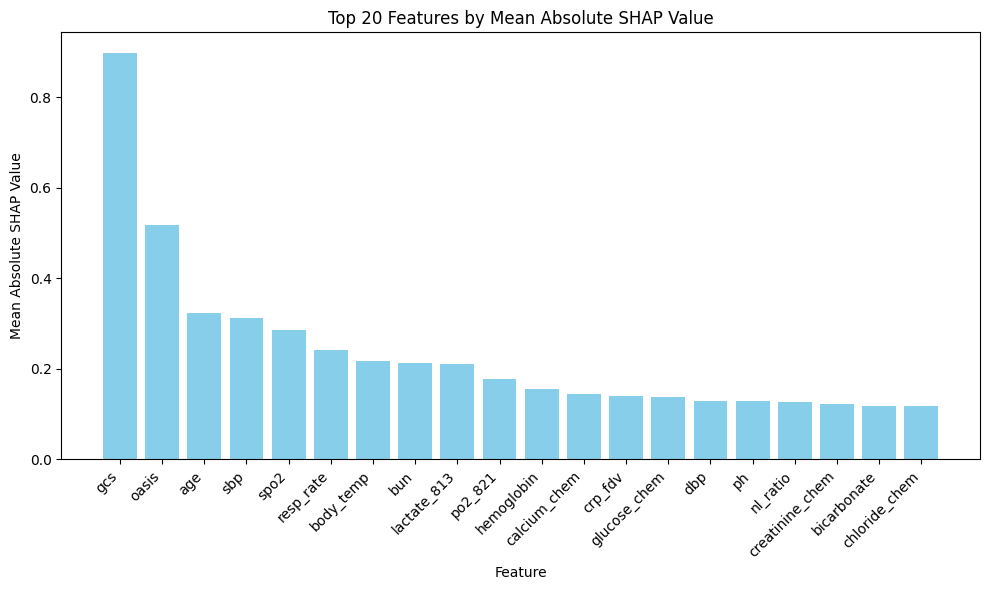

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

In [ ]:
results_by_model = {}
target_name = 'd48h'


results_by_model = run_models_for_target(
    X=X,
    y=y_d48h,
    target_name='d48h',
    columns_to_treat=None,
    distribution_results=distribution_results_cache,
    run_xgb_optimization=run_xgb_optimization,
    run_lgb_optimization=run_lgb_optimization,
    param_distributions_xgb=param_distributions_xgb,
    param_distributions_lgb=param_distributions_lgb,
    best_params_xgb=best_params_xgb,
    best_params_lgb=best_params_lgb
)


output_pdf = "results_d48h.pdf"
with PdfPages(output_pdf) as pdf:
    save_model_results_to_pdf(results_by_model, pdf, target_name='d48h')
print("Results saved to results_d48h.pdf.")

### d90d

In [ ]:
results_by_model = {}
target_name = 'd90d'

results_by_model = run_models_for_target(
    X=X,
    y=y_d90d,
    target_name='d90d',
    columns_to_treat=None,
    distribution_results=distribution_results_cache,
    run_xgb_optimization=run_xgb_optimization,
    run_lgb_optimization=run_lgb_optimization,
    param_distributions_xgb=param_distributions_xgb,
    param_distributions_lgb=param_distributions_lgb,
    best_params_xgb=best_params_xgb,
    best_params_lgb=best_params_lgb
)


output_pdf = "results_d90d.pdf"
with PdfPages(output_pdf) as pdf:
    save_model_results_to_pdf(results_by_model, pdf, target_name='d90d')
print("Results saved to results_d90d.pdf.")

Data split: X_train: (19680, 48), X_test: (4920, 48)
Before preprocessing: X_train=(19680, 48), X_test=(4920, 48)
Missing values imputed initially.
Outliers treated
Outliers treated and missing values re-imputed.
After preprocessing: X_train_encoded=(19680, 48), X_test_encoded=(4920, 48)
Preprocessing completed.
Training logistic regression (encoded)...


/usr/local/lib/python3.11/dist-packages/shap/explainers/_linear.py:95: FutureWarning: The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, maskers.Partition or maskers.Impute).
  warnings.warn(wmsg, FutureWarning)


Normalizing data using provided distribution results...
Skipping column diagnosis: No distribution result found.
Skipping normalization for binary column gender.
Skipping normalization for binary column mechvent.
Skipping normalization for binary column vasopressor.
Skipping column renal_replacement: No distribution result found.
Skipping column mild_liver_disease: No distribution result found.
Skipping column severe_liver_disease: No distribution result found.
Skipping column diabetes_with_cc: No distribution result found.
Skipping column diabetes_without_cc: No distribution result found.
Skipping column hypertension: No distribution result found.
Skipping column copd: No distribution result found.
Standardizing data...
Training logistic regression (normalized)...


/usr/local/lib/python3.11/dist-packages/shap/explainers/_linear.py:95: FutureWarning: The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, maskers.Partition or maskers.Impute).
  warnings.warn(wmsg, FutureWarning)


Training logistic regression (standardized)...


/usr/local/lib/python3.11/dist-packages/shap/explainers/_linear.py:95: FutureWarning: The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, maskers.Partition or maskers.Impute).
  warnings.warn(wmsg, FutureWarning)


Running XGBoost optimization...

[Phase 1] Randomized Search...
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:57:41] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2025-02-19 17:57:46,097] A new study created in memory with name: no-name-57379557-d45c-4846-8c07-45ec55ef6218


Best parameters from RandomizedSearchCV:
{'subsample': 0.8, 'scale_pos_weight': 1, 'reg_lambda': 2, 'reg_alpha': 0.5, 'n_estimators': 250, 'min_child_weight': 5, 'max_depth': 9, 'learning_rate': 0.05, 'gamma': 0.5, 'eval_metric': 'auc', 'colsample_bytree': 0.6}

[Phase 2] Optuna Bayesian Optimization...


[I 2025-02-19 17:58:06,642] Trial 0 finished with value: 0.8318519572829409 and parameters: {'max_depth': 9, 'min_child_weight': 5, 'gamma': 1, 'subsample': 0.8, 'colsample_bytree': 0.8, 'learning_rate': 0.01, 'scale_pos_weight': 4, 'reg_alpha': 0.1, 'reg_lambda': 3, 'n_estimators': 150, 'eval_metric': 'auc'}. Best is trial 0 with value: 0.8318519572829409.
[I 2025-02-19 17:58:14,847] Trial 1 finished with value: 0.8268403103483712 and parameters: {'max_depth': 7, 'min_child_weight': 3, 'gamma': 0, 'subsample': 0.6, 'colsample_bytree': 0.6, 'learning_rate': 0.01, 'scale_pos_weight': 8, 'reg_alpha': 1, 'reg_lambda': 2, 'n_estimators': 150, 'eval_metric': 'auc'}. Best is trial 0 with value: 0.8318519572829409.
[I 2025-02-19 17:58:25,281] Trial 2 finished with value: 0.8283151054608497 and parameters: {'max_depth': 9, 'min_child_weight': 3, 'gamma': 0.5, 'subsample': 0.6, 'colsample_bytree': 0.6, 'learning_rate': 0.1, 'scale_pos_weight': 10, 'reg_alpha': 0.1, 'reg_lambda': 1.5, 'n_estimat

### dinhosp

In [ ]:
results_by_model = {}
target_name = 'dinhosp'

results_by_model = run_models_for_target(
    X=X,
    y=y_dinhosp,
    target_name='dinhosp',
    columns_to_treat=None,
    distribution_results=distribution_results_cache,
    run_xgb_optimization=run_xgb_optimization,
    run_lgb_optimization=run_lgb_optimization,
    param_distributions_xgb=param_distributions_xgb,
    param_distributions_lgb=param_distributions_lgb,
    best_params_xgb=best_params_xgb,
    best_params_lgb=best_params_lgb
)


output_pdf = "results_dinhosp.pdf"
with PdfPages(output_pdf) as pdf:
    save_model_results_to_pdf(results_by_model, pdf, target_name='dinhosp')
print("Results saved to results_dinhosp.pdf.")

Data split: X_train: (19680, 48), X_test: (4920, 48)
Before preprocessing: X_train=(19680, 48), X_test=(4920, 48)
Missing values imputed initially.
Outliers treated
Outliers treated and missing values re-imputed.
After preprocessing: X_train_encoded=(19680, 48), X_test_encoded=(4920, 48)
Preprocessing completed.
Training logistic regression (encoded)...


/usr/local/lib/python3.11/dist-packages/shap/explainers/_linear.py:95: FutureWarning: The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, maskers.Partition or maskers.Impute).
  warnings.warn(wmsg, FutureWarning)


Normalizing data using provided distribution results...
Skipping column diagnosis: No distribution result found.
Skipping normalization for binary column gender.
Skipping normalization for binary column mechvent.
Skipping normalization for binary column vasopressor.
Skipping column renal_replacement: No distribution result found.
Skipping column mild_liver_disease: No distribution result found.
Skipping column severe_liver_disease: No distribution result found.
Skipping column diabetes_with_cc: No distribution result found.
Skipping column diabetes_without_cc: No distribution result found.
Skipping column hypertension: No distribution result found.
Skipping column copd: No distribution result found.
Standardizing data...
Training logistic regression (normalized)...


/usr/local/lib/python3.11/dist-packages/shap/explainers/_linear.py:95: FutureWarning: The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, maskers.Partition or maskers.Impute).
  warnings.warn(wmsg, FutureWarning)


Training logistic regression (standardized)...


/usr/local/lib/python3.11/dist-packages/shap/explainers/_linear.py:95: FutureWarning: The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, maskers.Partition or maskers.Impute).
  warnings.warn(wmsg, FutureWarning)


Training XGBoost model without optimization...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:19:25] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/shap/plots/_force_matplotlib.py:347: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=figsize)
<ipython-input-126-d4d1c0cd054d>:76: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.

xgb evaluated successfully.
Accuracy: 0.7313
AUC-ROC: 0.8185
MCC: 0.4667
F1 Score: 0.6831
Sensitivity (SE): 0.7795
Specificity (SP): 0.7028
Positive Predictive Value (PPV): 0.6079
Negative Predictive Value (NPV): 0.8436
Training LightGBM model without optimization...
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_gain_to_split is set=0.2, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [War

/usr/local/lib/python3.11/dist-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')
<ipython-input-126-d4d1c0cd054d>:41: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(12, 8))
<ipython-input-127-6ac44a6f1992>:29: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `

lgb evaluated successfully.
Accuracy: 0.7535
AUC-ROC: 0.8192
MCC: 0.4594
F1 Score: 0.6427
Sensitivity (SE): 0.5968
Specificity (SP): 0.8461
Positive Predictive Value (PPV): 0.6962
Negative Predictive Value (NPV): 0.7802
Results saved to results_dinhosp.pdf
Results saved to results_dinhosp.pdf.


## mortality prediction distribution

In [ ]:
# Define your targets dictionary and demographic columns
targets = {
    'd48h': y_d48h,
    'd90d': y_d90d,
    'dinhosp': y_dinhosp
}

demographic_cols = ['race', 'language', 'gender', 'insurance']

# Loop over each target and run the bias evaluation process
for target_name, y_target in targets.items():
    print(f"\nProcessing mortality prediction distribution for {target_name}")

    # Create a copy of Z without the target variables and metadata columns (like missing_count)
    Z_features = Z.drop(['d48h', 'd90d', 'dinhosp', 'missing_count'], axis=1, errors='ignore').copy()
    zmodel_feature_cols = Z_features.columns.tolist()

    # Assume no imputer is available (or provide one if you have a pre-trained imputer)
    target_imputer = 'imputer'

    mortality_prediction_distribution(
        Z=Z,
        y_target=y_target,
        target_name=target_name,
        zmodel_feature_cols=zmodel_feature_cols,
        best_params_xgb=best_params_xgb,
        imputer=target_imputer
    )

## demographic_bias on X pdf

In [ ]:
targets = {
    'd48h': y_d48h,
    'd90d': y_d90d,
    'dinhosp': y_dinhosp
}

demographics_data = Z[demographics].copy()
#adfinfo(demographics_data)
save_to_csv(demographics_data, 'demographics_data.csv')

X_features = Z.copy()

X_features = X_features.drop(['gender', 'language', 'race', 'insurance', 'missing_count'], axis=1)
#adfinfo(X_features)
save_to_csv(X_features, 'X_features.csv')




In [ ]:
# Iterate over each target and train models
for target_name, y_target in targets.items():
    print(f"\n--- Training Model for Target: {target_name} ---")
    output_pdf = f"/content/drive/MyDrive/demographic_mortality_plots_{target_name}.pdf"



    # Call the function with X_features and demographics_data
    model, X_train_prep, X_test_prep, y_train, y_test = train_xgb_and_plot_demographics(
        X=X_features,
        y=y_target,
        demographics_cols=demographics,
        demographics_data=demographics_data,
        preprocess_function=preprocess_data,
        model_params=best_params_xgb,
        plot_output_pdf=output_pdf,
        random_state=42
    )


## stratify_by_dem_Z pipeline

In [ ]:
# Define demographic-related column lists
demographics_cols = ['race', 'language', 'insurance']
demographic_cols_for_stratification = ['gender', 'race', 'language', 'insurance']
demographic_cols_to_drop = ['race', 'insurance', 'language']

# Append demographics to the feature set (X and Z must have the same number of rows)
X_with_demographics = append_demographics_to_X(X, Z, demographics_cols)
save_to_csv(X_with_demographics, 'X_with_demographics.csv')

# Run models on Z (this function returns results keyed by target names)
results_by_model, evaluation_results_on_Z = run_models_on_Z(
    X=X,
    Z=Z,
    y_d48h=y_d48h,
    y_d90d=y_d90d,
    y_dinhosp=y_dinhosp,
    run_xgb_optimization=run_xgb_optimization,
    run_lgb_optimization=run_lgb_optimization,
    param_distributions_xgb=param_distributions_xgb,
    param_distributions_lgb=param_distributions_lgb,
    best_params_xgb=best_params_xgb,
    best_params_lgb=best_params_lgb,
    columns_to_treat=None,
    distribution_results=distribution_results_cache,
    demographic_cols_for_stratification=demographic_cols_for_stratification,
    demographic_cols_to_drop=demographic_cols_to_drop,
    model_feature_cols=model_feature_cols
)

# Define targets dictionary for evaluation
targets = {
    'd48h': y_d48h,
    'd90d': y_d90d,
    'dinhosp': y_dinhosp
}

# For each target, extract its models dictionary and evaluate by demographics
for target_name, y_target in targets.items():
    y_true_aligned = y_target.reset_index(drop=True)
    output_pdf = f"demographic_evaluations_{target_name}.pdf"

    # Retrieve the models for the given target; exclude non-model keys such as 'imputer'
    models_dict = results_by_model.get(target_name, {})
    models_dict = {k: v for k, v in models_dict.items() if k != 'imputer'}

    # Call the evaluation function
    evaluate_models_by_demographics(
        models_dict=models_dict,
        X_with_demographics=X_with_demographics,
        y_true=y_true_aligned,
        demographics_cols=demographics_cols,
        output_pdf=output_pdf
    )
    print(f"Demographic evaluations for {target_name} saved to {output_pdf}.")

# Optionally, save overall evaluation results on Z to a PDF
overall_output_pdf = "results_on_Z.pdf"
with PdfPages(overall_output_pdf) as pdf:
    save_model_results_to_pdf(evaluation_results_on_Z, pdf)
print(f"Evaluation results on Z saved to {overall_output_pdf}.")

## get packages version

In [ ]:
import pkg_resources

def create_import_list_file():
    """
    Estrae tutti i pacchetti installati e le loro versioni, salvandoli in un file "import_list.txt".
    """
    installed_packages = pkg_resources.working_set
    packages_list = sorted(["{}=={}".format(pkg.project_name, pkg.version) for pkg in installed_packages])

    with open("import_list.txt", "w") as f:
        for package in packages_list:
            f.write(package + "\n")

    print("File 'import_list.txt' creato con successo.")

# Esegui la funzione per creare il file
create_import_list_file()